--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Number of high-resolution segments: 3274
Reducing problem size from 3274 variables to 164 variables.

Starting optimization... (This should be much faster!)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12812.022976672923
            Iterations: 96
            Function evaluations: 15901
            Gradient evaluations: 96
Optimization finished in 9.52 seconds.

--- Optimal Strategy Found ---
Minimized Race Time: 3.56 hours


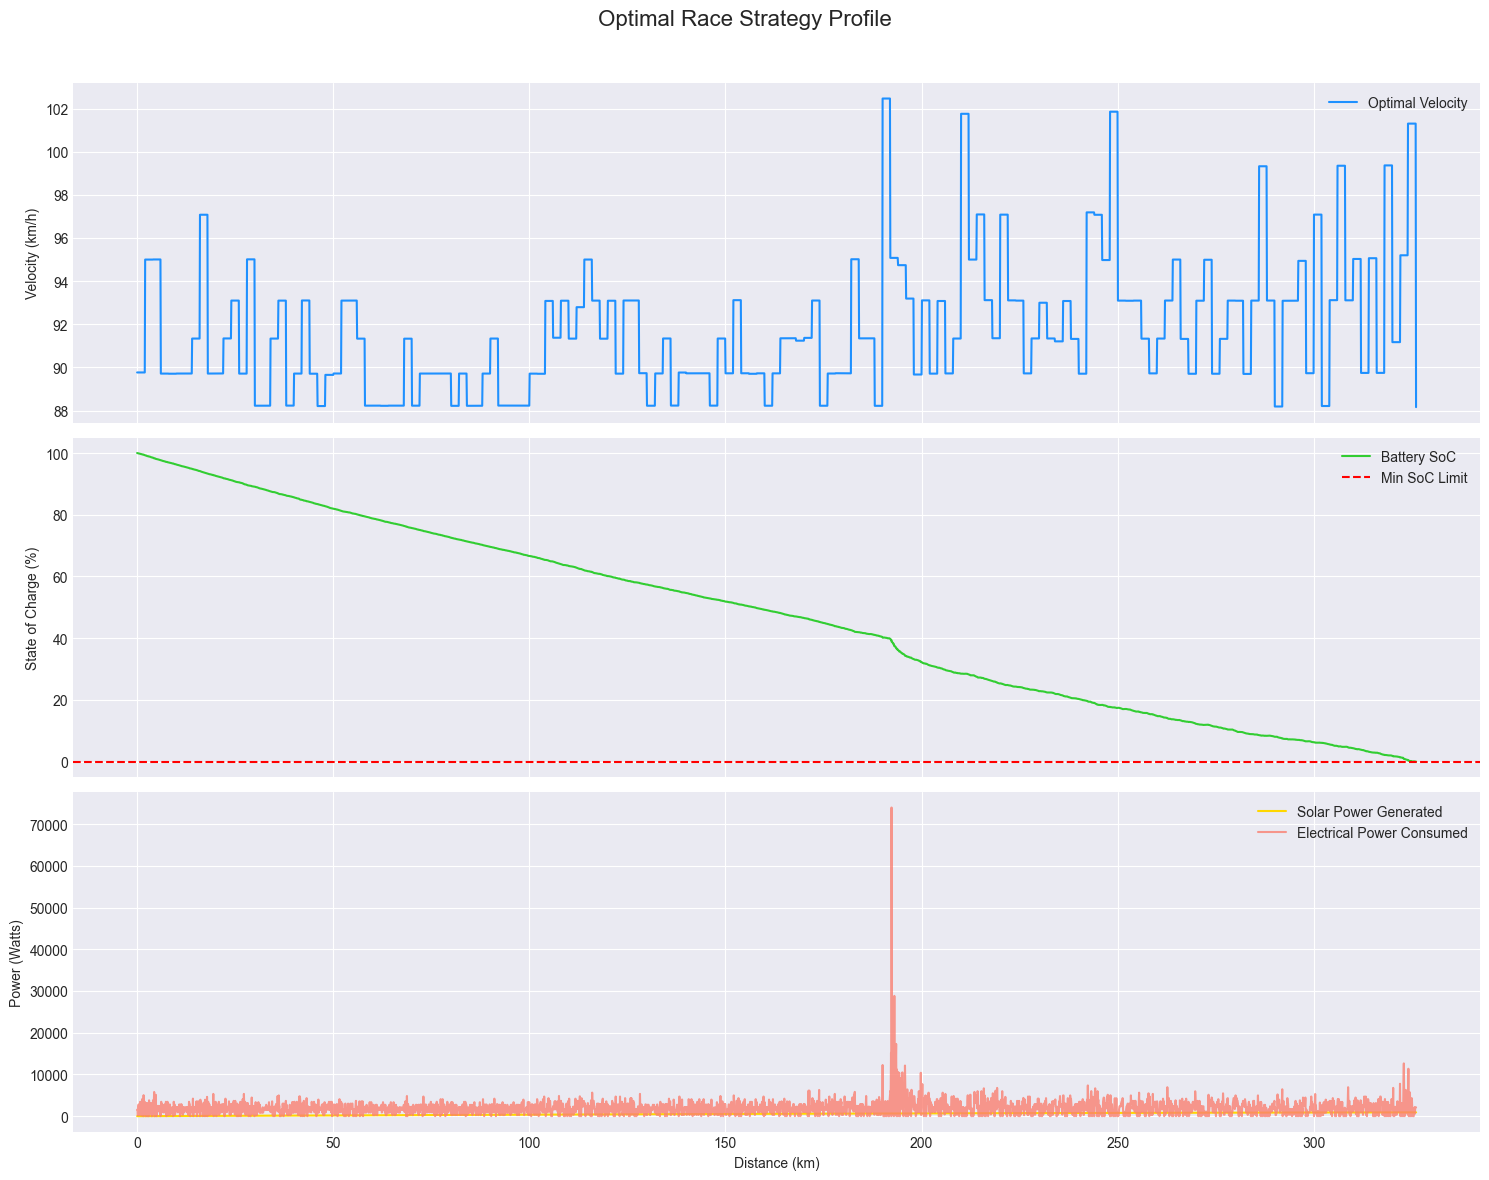

In [3]:
#--- AgniRath Race Strategy Optimization ---
#Route distance: 326.1 km
#Number of high-resolution segments: 3274
#Reducing problem size from 3274 variables to 164 variables.
#
#Starting optimization... (This should be much faster!)
#Optimization terminated successfully    (Exit mode 0)
#            Current function value: 12812.022976672923
#            Iterations: 96
#            Function evaluations: 15901
#            Gradient evaluations: 96
#Optimization finished in 9.23 seconds.
#
#--- Optimal Strategy Found ---
#Minimized Race Time: 3.56 hours

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters
        "vehicle_mass": 250.0,  # kg (car + driver)
        "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
        "coeff_rolling_resistance_Crr": 0.006,
        "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
        # Battery
        "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
        "initial_SoC": 1.0,  # Start with a full battery (100%)
        "min_SoC": 0.0,      # Minimum allowed SoC

        # Solar Array
        "solar_panel_area": 4.0,       # m^2
        "solar_panel_efficiency": 0.24,  # 24%

        # Environmental Constants
        "air_density": 1.225,  # kg/m^3
        "gravity": 9.81,       # m/s^2
    }

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

def load_route_data(filename='route_data_resampled.csv'):
    """Loads and prepares the route data from the CSV file."""
    df = pd.read_csv(filename)
    
    # Calculate segment lengths and gradients from the route data
    # We use np.diff to find the difference between consecutive elements
    distances_m = haversine_distance(df['latitude'].iloc[:-1].values, 
                                     df['longitude'].iloc[:-1].values, 
                                     df['latitude'].iloc[1:].values, 
                                     df['longitude'].iloc[1:].values)
    
    # Prepend a 0 for the start of the first segment
    df['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Gradient is the change in altitude over the distance of the segment
    altitudes_m = df['altitude_m'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)
    # The sine of the slope angle is rise/run (delta_altitude / segment_distance)
    # We use np.clip to avoid division by zero for any zero-length segments
    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    df['gradient_sin_theta'] = np.insert(sin_theta, 0, 0)
    
    # The total distance is the cumulative sum of segment distances
    df['cumulative_distance_m'] = df['segment_distance_m'].cumsum()
    
    return df

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

def run_race_simulation(velocities_kph, route_df, params):
    """
    Simulates the entire race for a given velocity profile.
    
    Args:
        velocities_kph (np.array): An array of velocities (km/h) for each segment.
        route_df (pd.DataFrame): The prepared route data.
        params (dict): The vehicle parameters.

    Returns:
        tuple: (total_time_s, soc_profile, power_profile)
    """
    # Convert velocities from km/h to m/s for physics calculations
    velocities_mps = velocities_kph / 3.6
    
    # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
    # Resistive Forces
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
    F_resistive = F_drag + F_rolling + F_gradient
    # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
    F_tractive = np.maximum(0, F_resistive)

    # Power Calculations
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Time and Energy Simulation (Iterative) ---
    
    segment_distances = route_df['segment_distance_m'].values
    # Calculate time taken for each segment (delta_t = delta_d / v)
    # Add a small epsilon to velocity to avoid division by zero
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
    total_time_s = np.sum(delta_t_s)
    
    # Calculate time of day for each segment to get solar irradiance
    time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
    P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    
    # Net power flow for each segment (solar generation - electrical consumption)
    P_net_watts = P_solar_watts - P_elec_watts
    
    # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
    delta_energy_joules = P_net_watts * delta_t_s
    
    # Calculate the battery energy level over the whole race
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
    # Convert energy profile to State of Charge (SoC) profile
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    # Package power data for plotting
    power_profile = {
        'solar_gen_W': P_solar_watts,
        'elec_cons_W': P_elec_watts
    }
    
    return total_time_s, soc_profile, power_profile

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# ADD THIS NEW HELPER FUNCTION HERE
def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    For example, chunk_velocities[0] applies to the first 2km of the race.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
    # The last index might be out of bounds if the total distance isn't a perfect
    # multiple of the chunk size, so we clip it to the last valid index.
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(chunk_velocities, route_df, params, chunk_size_m):
    """The function the optimizer tries to minimize. Returns total race time."""
    # First, create the full velocity profile from the chunk velocities
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    
    # Then run the full simulation as before
    total_time_s, _, _ = run_race_simulation(velocities_kph, route_df, params)
    return total_time_s

# REPLACE the old constraint_function with this one
def constraint_function(chunk_velocities, route_df, params, chunk_size_m):
    """
    The constraint the optimizer must obey.
    Returns the SoC profile. The optimizer will ensure all values are >= min_SoC.
    """
    # First, create the full velocity profile from the chunk velocities
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    
    # Then run the full simulation as before
    _, soc_profile, _ = run_race_simulation(velocities_kph, route_df, params)
    
    # The constraint is soc_profile - min_SoC >= 0
    return soc_profile - params['min_SoC']

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================

# REPLACE your entire 'if __name__ == "__main__":' block with this
if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    num_segments = len(route_data)
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Number of high-resolution segments: {num_segments}")
    
    # --- Define Optimization Problem ---
    
    # ADDED: Define the size of our new, larger "super-segments"
    # This is the key parameter to trade off speed vs. profile detail.
    CHUNK_SIZE_M = 2000  # Optimize velocity every 2 km

    # ADDED: Calculate how many new, smaller decision variables we will have
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    print(f"Reducing problem size from {num_segments} variables to {num_chunks} variables.")
    
    # 1. Initial Guess: A constant velocity of 80 km/h for the new number of chunks
    initial_velocity_guess = np.full(num_chunks, 80.0) # CHANGED: use num_chunks
    
    # 2. Bounds: Velocity must be between 10 km/h and 130 km/h for each chunk
    velocity_bounds = [(10.0, 130.0) for _ in range(num_chunks)] # CHANGED: use num_chunks
    
    # 3. Constraints: The constraint function now needs chunk_size_m passed to it
    soc_constraint = {'type': 'ineq', 
                      'fun': constraint_function, 
                      'args': (route_data, vehicle_params, CHUNK_SIZE_M)} # CHANGED: Added CHUNK_SIZE_M to args

    # --- Run the Optimizer ---
    print("\nStarting optimization... (This should be much faster!)")
    start_time = time.time()
    
    # We use the SLSQP (Sequential Least Squares Programming) solver
    result = minimize(
        objective_function,
        initial_velocity_guess,
        args=(route_data, vehicle_params, CHUNK_SIZE_M), # CHANGED: Added CHUNK_SIZE_M to args
        method='SLSQP',
        bounds=velocity_bounds,
        constraints=[soc_constraint],
        options={'disp': True, 'maxiter': 200} # CHANGED: Increased maxiter slightly, as it will run much faster
    )
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

    # --- Process and Display Results ---
    if result.success:
        # CHANGED: result.x is now the short array of chunk velocities.
        # We must map it back to the full profile before plotting.
        optimal_chunk_velocities = result.x
        optimal_velocities_kph = map_chunk_velocities_to_segments(
            optimal_chunk_velocities, route_data, CHUNK_SIZE_M
        )
        
        # Rerun the simulation with the optimal profile to get final data
        final_time_s, final_soc, final_power = run_race_simulation(
            optimal_velocities_kph, route_data, vehicle_params
        )
        
        final_time_hr = final_time_s / 3600.0
        print(f"\n--- Optimal Strategy Found ---")
        print(f"Minimized Race Time: {final_time_hr:.2f} hours")
        
        # --- Visualization ---
        distance_km = route_data['cumulative_distance_m'] / 1000.0
        
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        fig.suptitle('Optimal Race Strategy Profile', fontsize=16)
        
        # 1. Velocity vs. Distance
        ax1.plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
        ax1.set_ylabel('Velocity (km/h)')
        ax1.legend()
        
        # 2. SoC vs. Distance
        ax2.plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
        ax2.set_ylabel('State of Charge (%)')
        ax2.axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label='Min SoC Limit')
        ax2.legend()
        
        # 3. Power vs. Distance
        ax3.plot(distance_km, final_power['solar_gen_W'], label='Solar Power Generated', color='gold')
        ax3.plot(distance_km, final_power['elec_cons_W'], label='Electrical Power Consumed', color='salmon', alpha=0.8)
        ax3.set_xlabel('Distance (km)')
        ax3.set_ylabel('Power (Watts)')
        ax3.legend()
        
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

    else:
        print("\nOptimization failed to find a solution.")
        print(result.message)

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 327 velocity chunks + 1 start time variable.

Starting optimization...
  ... Iteration 5/50 complete.
  ... Iteration 10/50 complete.
  ... Iteration 15/50 complete.
  ... Iteration 20/50 complete.
  ... Iteration 25/50 complete.
  ... Iteration 30/50 complete.
  ... Iteration 35/50 complete.
  ... Iteration 40/50 complete.
  ... Iteration 45/50 complete.
  ... Iteration 50/50 complete.
Iteration limit reached    (Exit mode 9)
            Current function value: 12514.946098833163
            Iterations: 50
            Function evaluations: 16788
            Gradient evaluations: 51
Optimization finished in 15.25 seconds.

--- Optimization Timed Out: Using Best Intermediate Solution Found ---
Optimal Race Start Time: 11:00
Minimized Race Time: 6.44 hours
Total Solar Energy Generated: 6.80 kWh
Total Electrical Energy Consumed: 3.96 kWh
Final Battery Level: 

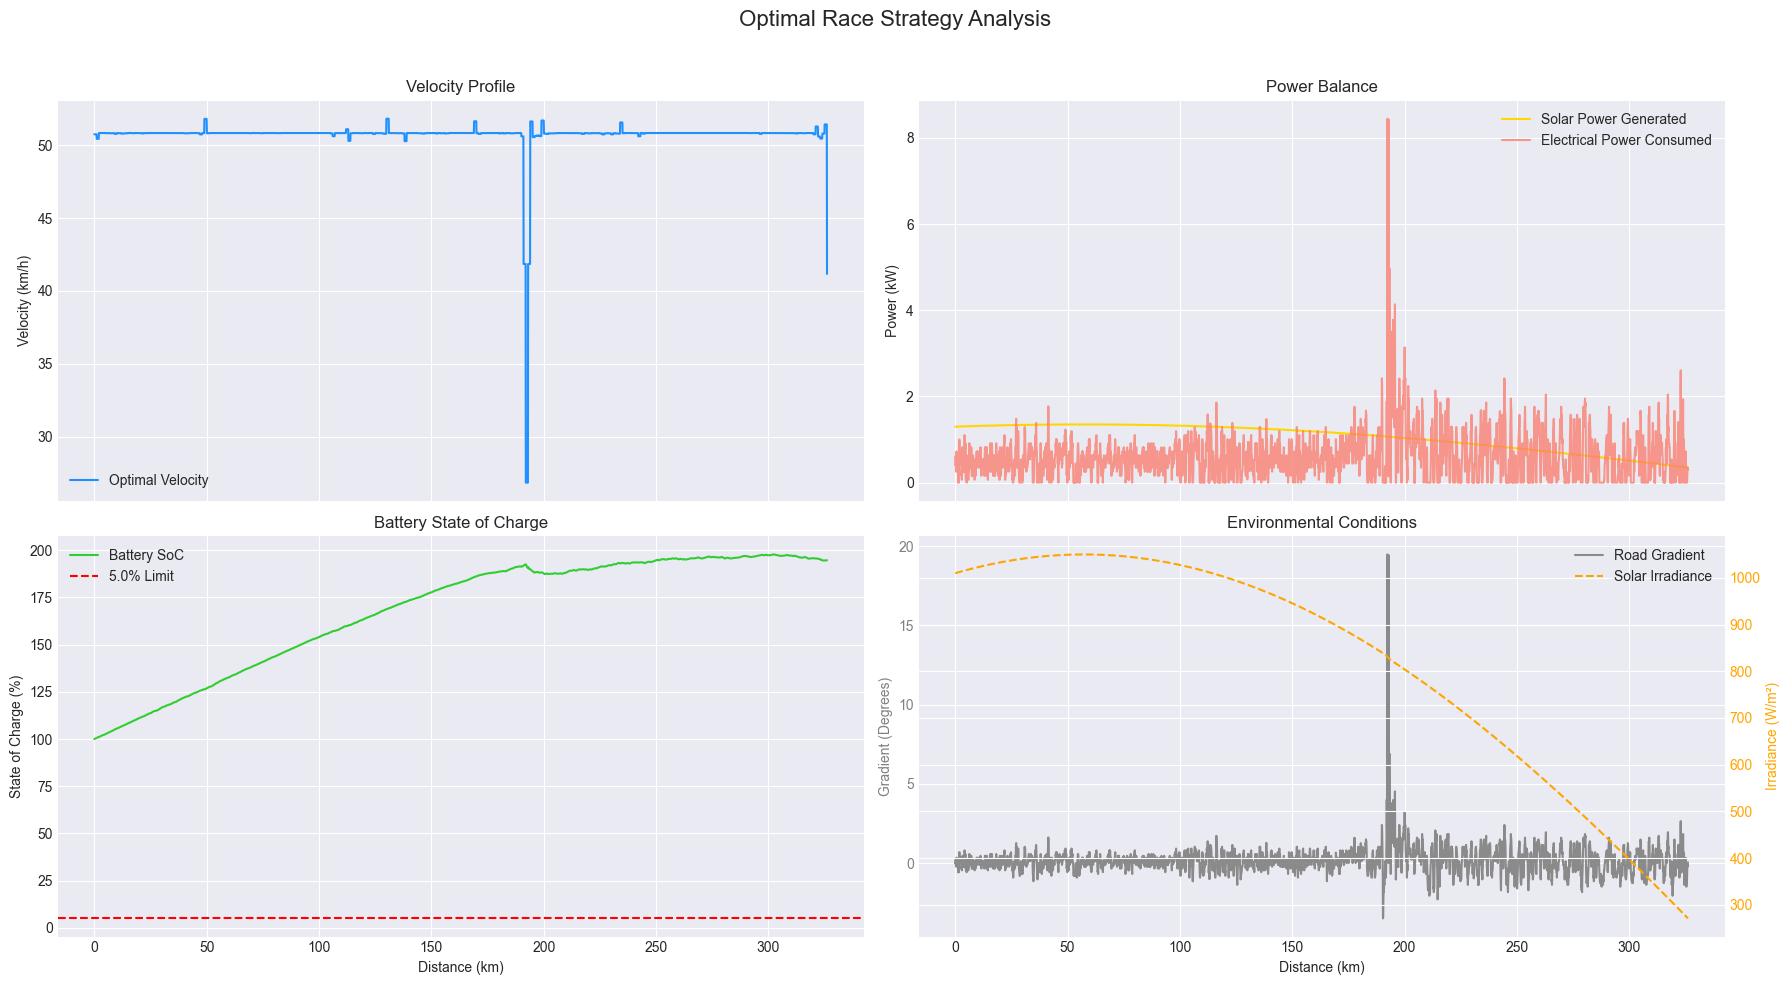

In [6]:
# ... Iteration 50/50 complete.
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12514.946098833163
#             Iterations: 50
#             Function evaluations: 16788
#             Gradient evaluations: 51
# Optimization finished in 13.81 seconds.

# --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 11:00
# Minimized Race Time: 6.44 hours
# Total Solar Energy Generated: 6.80 kWh
# Total Electrical Energy Consumed: 3.96 kWh
# Final Battery Level: 194.7% (5.84 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.05,
        "max_battery_current_a": 80.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 15.0,
        "max_deceleration_kph_per_chunk": 15.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    For example, chunk_velocities[0] applies to the first 2km of the race.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
    # The last index might be out of bounds if the total distance isn't a perfect
    # multiple of the chunk size, so we clip it to the last valid index.
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# REPLACE your constraint_function with this
def constraint_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    _, soc_profile, _, battery_current_profile, _ = \
        run_race_simulation(velocities_kph, route_df, params, start_hour)
    
    # Constraint 1: SoC
    c1_soc = soc_profile - params['min_SoC']
    
    # Constraint 2: Battery current
    c2_battery_current = params['max_battery_current_a'] - battery_current_profile
    
    # REMOVED the motor temp constraint
    return np.hstack([c1_soc, c2_battery_current])

# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# REPLACE your entire 'if __name__ == "__main__":' block with this
if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 1000
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    initial_start_hour = 11.0
    initial_velocities = np.full(num_chunks, 40.0)
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 14.0)
    velocity_bounds = [(10.0, 130.0) for _ in range(num_chunks)]
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}

    # --- Setup the Upgraded Progress Callback ---
    MAX_ITER = 50 # A reasonable limit for this problem
    progress_callback = OptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization...")
    start_time = time.time()
    
    result = minimize(
        objective_function,
        initial_guess,
        args=args_tuple,
        method='SLSQP',
        bounds=bounds,
        constraints=[soc_constraint_def, accel_constraint_def],
        callback=progress_callback,
        options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-6}
    )
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

    # --- Process and Display Results ---
    # ADDED: Logic to use the 'best so far' result if optimization fails
    solution_x = None
    if result.success:
        print("\n--- Optimal Strategy Found ---")
        solution_x = result.x
    elif progress_callback.last_valid_x is not None:
        print("\n--- Optimization Timed Out: Using Best Intermediate Solution Found ---")
        solution_x = progress_callback.last_valid_x
    else:
        print("\nOptimization failed and no valid intermediate solution was found.")

    if solution_x is not None:
        optimal_start_hour = solution_x[0]
        optimal_chunk_velocities = solution_x[1:]
        
        optimal_velocities_kph = map_chunk_velocities_to_segments(
            optimal_chunk_velocities, route_data, CHUNK_SIZE_M
        )
        
        final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
            optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
        )
        
        final_time_hr = final_time_s / 3600.0
        print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
        print(f"Minimized Race Time: {final_time_hr:.2f} hours")
        
        total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
        total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
        final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

        print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
        print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
        print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
        
        # --- ENHANCED VISUALIZATION ---
        distance_km = route_data['cumulative_distance_m'] / 1000.0
        
        plt.style.use('seaborn-v0_8-darkgrid')
        # CHANGED: Switched to a 2x2 grid for better layout
        fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
        fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
        
        # 1. Velocity Profile
        ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
        ax[0, 0].set_ylabel('Velocity (km/h)')
        ax[0, 0].set_title('Velocity Profile')
        ax[0, 0].legend()
        
        # 2. State of Charge (SoC)
        ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
        ax[1, 0].set_ylabel('State of Charge (%)')
        ax[1, 0].set_title('Battery State of Charge')
        ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
        ax[1, 0].set_xlabel('Distance (km)')
        ax[1, 0].legend()
        
        # 3. Power Balance
        ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
        ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
        ax[0, 1].set_ylabel('Power (kW)')
        ax[0, 1].set_title('Power Balance')
        ax[0, 1].legend()

        # 4. ADDED: Environmental Conditions
        gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
        irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

        ax_env = ax[1, 1]
        ax_solar = ax_env.twinx() # Create a second y-axis

        ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
        ax_env.set_ylabel('Gradient (Degrees)', color='grey')
        ax_env.tick_params(axis='y', labelcolor='grey')
        ax_env.set_title('Environmental Conditions')
        ax_env.set_xlabel('Distance (km)')

        ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
        ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
        ax_solar.tick_params(axis='y', labelcolor='orange')

        # To get legends from both axes to show up
        lines, labels = ax_env.get_legend_handles_labels()
        lines2, labels2 = ax_solar.get_legend_handles_labels()
        ax_solar.legend(lines + lines2, labels + labels2, loc=0)
        
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

In [ ]:
#   ... Iteration 50/50 complete.
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12514.924281066047
#             Iterations: 50
#             Function evaluations: 16781
#             Gradient evaluations: 51
# Optimization finished in 24.44 seconds.

# --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 14:00
# Minimized Race Time: 4.33 hours
# Total Solar Energy Generated: 3.03 kWh
# Total Electrical Energy Consumed: 5.63 kWh
# Final Battery Level: 13.4% (0.40 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.05,
        "max_SoC": 1.01, # ADDED: The battery cannot exceed 100%
        "max_battery_current_a": 80.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 15.0,
        "max_deceleration_kph_per_chunk": 15.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='Agnirath_app/route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    For example, chunk_velocities[0] applies to the first 2km of the race.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
    # The last index might be out of bounds if the total distance isn't a perfect
    # multiple of the chunk size, so we clip it to the last valid index.
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# REPLACE your constraint_function with this
def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function, now including an upper limit on SoC.
    """
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    
    _, soc_profile, _, battery_current_profile, _ = \
        run_race_simulation(velocities_kph, route_df, params, start_hour)
    
    # Constraint 1: SoC must be ABOVE the minimum
    c1_min_soc = soc_profile - params['min_SoC']
    
    # ADDED Constraint 2: SoC must be BELOW the maximum
    c2_max_soc = params['max_SoC'] - soc_profile
    
    # Constraint 3: Battery current must be below the maximum
    c3_battery_current = params['max_battery_current_a'] - battery_current_profile
    
    # Stack all constraints into a single array for the optimizer
    return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])

# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# REPLACE your entire 'if __name__ == "__main__":' block with this
if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 1000 # Using 2km chunks is a good balance of speed and detail
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # CHANGED: A more aggressive initial guess to encourage a faster solution
    initial_start_hour = 10.0
    initial_velocities = np.full(num_chunks, 40.0)
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 14.0)
    velocity_bounds = [(10.0, 130.0) for _ in range(num_chunks)]
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}

    # --- Setup the Upgraded Progress Callback ---
    MAX_ITER = 50 # CHANGED: Give the optimizer more iterations to converge
    progress_callback = OptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization for the final result...")
    start_time = time.time()
    
    result = minimize(
        objective_function,
        initial_guess,
        args=args_tuple,
        method='SLSQP',
        bounds=bounds,
        constraints=[soc_constraint_def, accel_constraint_def],
        callback=progress_callback,
        options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7} # Using a slightly tighter tolerance
    )
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

    # --- Process and Display Results ---
    # ADDED: Logic to use the 'best so far' result if optimization fails
    solution_x = None
    if result.success:
        print("\n--- Optimal Strategy Found ---")
        solution_x = result.x
    elif progress_callback.last_valid_x is not None:
        print("\n--- Optimization Timed Out: Using Best Intermediate Solution Found ---")
        solution_x = progress_callback.last_valid_x
    else:
        print("\nOptimization failed and no valid intermediate solution was found.")

    if solution_x is not None:
        optimal_start_hour = solution_x[0]
        optimal_chunk_velocities = solution_x[1:]
        
        optimal_velocities_kph = map_chunk_velocities_to_segments(
            optimal_chunk_velocities, route_data, CHUNK_SIZE_M
        )
        
        final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
            optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
        )
        
        final_time_hr = final_time_s / 3600.0
        print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
        print(f"Minimized Race Time: {final_time_hr:.2f} hours")
        
        total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
        total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
        final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

        print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
        print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
        print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
        
        # --- ENHANCED VISUALIZATION ---
        distance_km = route_data['cumulative_distance_m'] / 1000.0
        
        plt.style.use('seaborn-v0_8-darkgrid')
        # CHANGED: Switched to a 2x2 grid for better layout
        fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
        fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
        
        # 1. Velocity Profile
        ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
        ax[0, 0].set_ylabel('Velocity (km/h)')
        ax[0, 0].set_title('Velocity Profile')
        ax[0, 0].legend()
        
        # 2. State of Charge (SoC)
        ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
        ax[1, 0].set_ylabel('State of Charge (%)')
        ax[1, 0].set_title('Battery State of Charge')
        ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
        ax[1, 0].set_xlabel('Distance (km)')
        ax[1, 0].legend()
        
        # 3. Power Balance
        ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
        ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
        ax[0, 1].set_ylabel('Power (kW)')
        ax[0, 1].set_title('Power Balance')
        ax[0, 1].legend()

        # 4. ADDED: Environmental Conditions
        gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
        irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

        ax_env = ax[1, 1]
        ax_solar = ax_env.twinx() # Create a second y-axis

        ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
        ax_env.set_ylabel('Gradient (Degrees)', color='grey')
        ax_env.tick_params(axis='y', labelcolor='grey')
        ax_env.set_title('Environmental Conditions')
        ax_env.set_xlabel('Distance (km)')

        ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
        ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
        ax_solar.tick_params(axis='y', labelcolor='orange')

        # To get legends from both axes to show up
        lines, labels = ax_env.get_legend_handles_labels()
        lines2, labels2 = ax_solar.get_legend_handles_labels()
        ax_solar.legend(lines + lines2, labels + labels2, loc=0)
        
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

In [ ]:
# ... Iteration 50/50 complete.
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12628.221067944593
#             Iterations: 50
#             Function evaluations: 16783
#             Gradient evaluations: 51
# Optimization finished in 36.99 seconds.

# --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 10:18
# Minimized Race Time: 3.51 hours
# Total Solar Energy Generated: 4.60 kWh
# Total Electrical Energy Consumed: 7.45 kWh
# Final Battery Level: 5.0% (0.15 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.05,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 15.0,
        "max_deceleration_kph_per_chunk": 15.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='Agnirath_app/route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    For example, chunk_velocities[0] applies to the first 2km of the race.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
    # The last index might be out of bounds if the total distance isn't a perfect
    # multiple of the chunk size, so we clip it to the last valid index.
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# REPLACE your constraint_function with this
def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function, now including an upper limit on SoC.
    """
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    
    _, soc_profile, _, battery_current_profile, _ = \
        run_race_simulation(velocities_kph, route_df, params, start_hour)
    
    # Constraint 1: SoC must be ABOVE the minimum
    c1_min_soc = soc_profile - params['min_SoC']
    
    # ADDED Constraint 2: SoC must be BELOW the maximum
    c2_max_soc = params['max_SoC'] - soc_profile
    
    # Constraint 3: Battery current must be below the maximum
    c3_battery_current = params['max_battery_current_a'] - battery_current_profile
    
    # Stack all constraints into a single array for the optimizer
    return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])

# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# REPLACE your entire 'if __name__ == "__main__":' block with this
if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 1000 # Using 2km chunks is a good balance of speed and detail
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # CHANGED: A more aggressive initial guess to encourage a faster solution
    initial_start_hour = 10.0
    initial_velocities = np.full(num_chunks, 40.0)
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(10.0, 130.0) for _ in range(num_chunks)]
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}

    # --- Setup the Upgraded Progress Callback ---
    MAX_ITER = 50 # CHANGED: Give the optimizer more iterations to converge
    progress_callback = OptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization for the final result...")
    start_time = time.time()
    
    result = minimize(
        objective_function,
        initial_guess,
        args=args_tuple,
        method='SLSQP',
        bounds=bounds,
        constraints=[soc_constraint_def, accel_constraint_def],
        callback=progress_callback,
        options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7} # Using a slightly tighter tolerance
    )
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

    # --- Process and Display Results ---
    # ADDED: Logic to use the 'best so far' result if optimization fails
    solution_x = None
    if result.success:
        print("\n--- Optimal Strategy Found ---")
        solution_x = result.x
    elif progress_callback.last_valid_x is not None:
        print("\n--- Optimization Timed Out: Using Best Intermediate Solution Found ---")
        solution_x = progress_callback.last_valid_x
    else:
        print("\nOptimization failed and no valid intermediate solution was found.")

    if solution_x is not None:
        optimal_start_hour = solution_x[0]
        optimal_chunk_velocities = solution_x[1:]
        
        optimal_velocities_kph = map_chunk_velocities_to_segments(
            optimal_chunk_velocities, route_data, CHUNK_SIZE_M
        )
        
        final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
            optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
        )
        
        final_time_hr = final_time_s / 3600.0
        print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
        print(f"Minimized Race Time: {final_time_hr:.2f} hours")
        
        total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
        total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
        final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

        print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
        print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
        print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
        
        # --- ENHANCED VISUALIZATION ---
        distance_km = route_data['cumulative_distance_m'] / 1000.0
        
        plt.style.use('seaborn-v0_8-darkgrid')
        # CHANGED: Switched to a 2x2 grid for better layout
        fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
        fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
        
        # 1. Velocity Profile
        ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
        ax[0, 0].set_ylabel('Velocity (km/h)')
        ax[0, 0].set_title('Velocity Profile')
        ax[0, 0].legend()
        
        # 2. State of Charge (SoC)
        ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
        ax[1, 0].set_ylabel('State of Charge (%)')
        ax[1, 0].set_title('Battery State of Charge')
        ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
        ax[1, 0].set_xlabel('Distance (km)')
        ax[1, 0].legend()
        
        # 3. Power Balance
        ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
        ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
        ax[0, 1].set_ylabel('Power (kW)')
        ax[0, 1].set_title('Power Balance')
        ax[0, 1].legend()

        # 4. ADDED: Environmental Conditions
        gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
        irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

        ax_env = ax[1, 1]
        ax_solar = ax_env.twinx() # Create a second y-axis

        ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
        ax_env.set_ylabel('Gradient (Degrees)', color='grey')
        ax_env.tick_params(axis='y', labelcolor='grey')
        ax_env.set_title('Environmental Conditions')
        ax_env.set_xlabel('Distance (km)')

        ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
        ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
        ax_solar.tick_params(axis='y', labelcolor='orange')

        # To get legends from both axes to show up
        lines, labels = ax_env.get_legend_handles_labels()
        lines2, labels2 = ax_solar.get_legend_handles_labels()
        ax_solar.legend(lines + lines2, labels + labels2, loc=0)
        
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Agnirath_app/route_data_resampled.csv'

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 327 velocity chunks + 1 start time variable.

Starting optimization for the final result...
  ... Iteration 5/50 complete.
  ... Iteration 10/50 complete.
  ... Iteration 15/50 complete.
  ... Iteration 20/50 complete.
  ... Iteration 25/50 complete.
  ... Iteration 30/50 complete.
  ... Iteration 35/50 complete.
  ... Iteration 40/50 complete.
  ... Iteration 45/50 complete.
  ... Iteration 50/50 complete.
Iteration limit reached    (Exit mode 9)
            Current function value: 12628.221067944593
            Iterations: 50
            Function evaluations: 16783
            Gradient evaluations: 51
Optimization finished in 20.87 seconds.

--- Optimization Timed Out: Using Best Intermediate Solution Found ---
Optimal Race Start Time: 10:18
Minimized Race Time: 3.51 hours
Total Solar Energy Generated: 4.60 kWh
Total Electrical Energy Consumed: 7.45 kWh


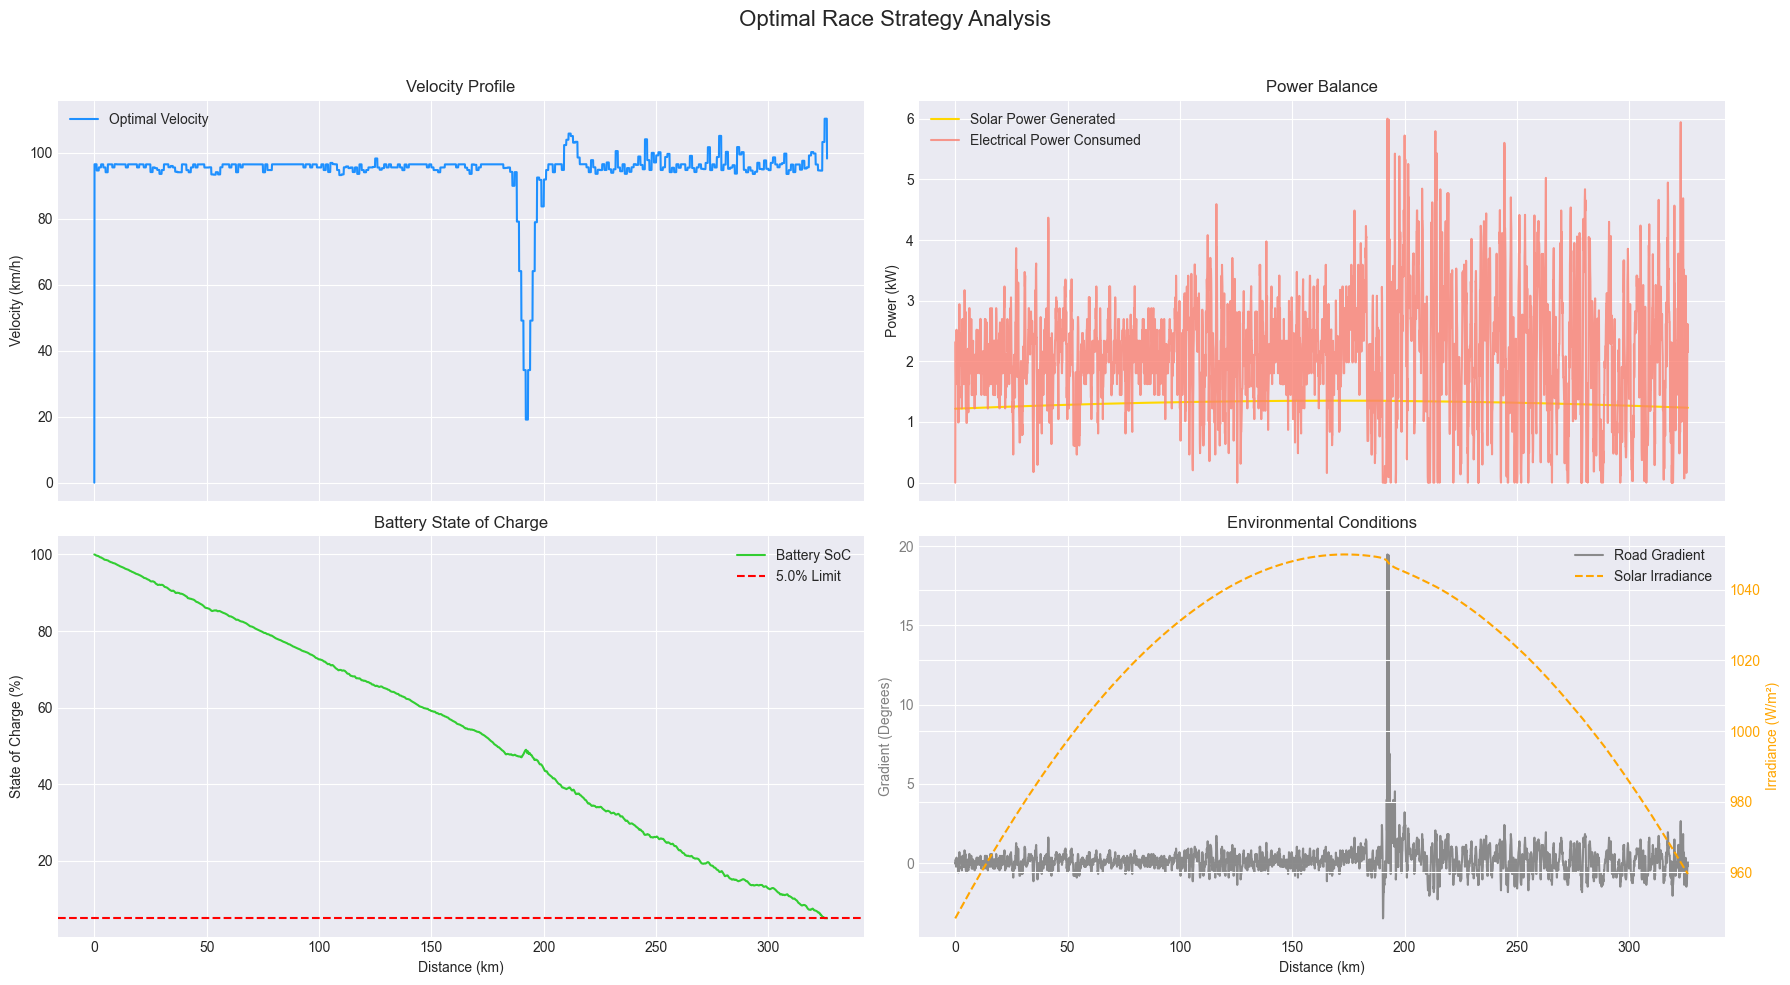

In [7]:
# The speed starts from 0

# ... Iteration 50/50 complete.
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12628.221067944593
#             Iterations: 50
#             Function evaluations: 16783
#             Gradient evaluations: 51
# Optimization finished in 19.56 seconds.

# --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 10:18
# Minimized Race Time: 3.51 hours
# Total Solar Energy Generated: 4.60 kWh
# Total Electrical Energy Consumed: 7.45 kWh
# Final Battery Level: 5.0% (0.15 kWh)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.05,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 15.0,
        "max_deceleration_kph_per_chunk": 15.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
# def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
#     """
#     Takes a small array of velocities and maps them to the full route.
#     For example, chunk_velocities[0] applies to the first 2km of the race.
#     """
#     # Get the cumulative distance for each high-resolution segment
#     cumulative_dist = route_df['cumulative_distance_m'].values
    
#     # Determine which chunk each segment belongs to by its distance
#     # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
#     segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
#     # The last index might be out of bounds if the total distance isn't a perfect
#     # multiple of the chunk size, so we clip it to the last valid index.
#     segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
#     # Use the indices to create the full-length velocity profile from the chunk velocities
#     full_velocity_profile = chunk_velocities[segment_chunk_indices]
#     return full_velocity_profile

def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Includes a modification to ensure the car starts at 0 km/h.
    """
    cumulative_dist = route_df['cumulative_distance_m'].values
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # --- FINAL MODIFICATION: Force the start velocity to be zero ---
    full_velocity_profile[0] = 0.0
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# REPLACE your constraint_function with this
def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function, now including an upper limit on SoC.
    """
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    
    _, soc_profile, _, battery_current_profile, _ = \
        run_race_simulation(velocities_kph, route_df, params, start_hour)
    
    # Constraint 1: SoC must be ABOVE the minimum
    c1_min_soc = soc_profile - params['min_SoC']
    
    # ADDED Constraint 2: SoC must be BELOW the maximum
    c2_max_soc = params['max_SoC'] - soc_profile
    
    # Constraint 3: Battery current must be below the maximum
    c3_battery_current = params['max_battery_current_a'] - battery_current_profile
    
    # Stack all constraints into a single array for the optimizer
    return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])

# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# REPLACE your entire 'if __name__ == "__main__":' block with this
if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 1000 # Using 2km chunks is a good balance of speed and detail
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # CHANGED: A more aggressive initial guess to encourage a faster solution
    initial_start_hour = 10.0
    initial_velocities = np.full(num_chunks, 40.0)
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(10.0, 130.0) for _ in range(num_chunks)]
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}

    # --- Setup the Upgraded Progress Callback ---
    MAX_ITER = 50 # CHANGED: Give the optimizer more iterations to converge
    progress_callback = OptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization for the final result...")
    start_time = time.time()
    
    result = minimize(
        objective_function,
        initial_guess,
        args=args_tuple,
        method='SLSQP',
        bounds=bounds,
        constraints=[soc_constraint_def, accel_constraint_def],
        callback=progress_callback,
        options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7} # Using a slightly tighter tolerance
    )
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

    # --- Process and Display Results ---
    # ADDED: Logic to use the 'best so far' result if optimization fails
    solution_x = None
    if result.success:
        print("\n--- Optimal Strategy Found ---")
        solution_x = result.x
    elif progress_callback.last_valid_x is not None:
        print("\n--- Optimization Timed Out: Using Best Intermediate Solution Found ---")
        solution_x = progress_callback.last_valid_x
    else:
        print("\nOptimization failed and no valid intermediate solution was found.")

    if solution_x is not None:
        optimal_start_hour = solution_x[0]
        optimal_chunk_velocities = solution_x[1:]
        
        optimal_velocities_kph = map_chunk_velocities_to_segments(
            optimal_chunk_velocities, route_data, CHUNK_SIZE_M
        )
        
        final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
            optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
        )
        
        final_time_hr = final_time_s / 3600.0
        print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
        print(f"Minimized Race Time: {final_time_hr:.2f} hours")
        
        total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
        total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
        final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

        print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
        print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
        print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
        
        # --- ENHANCED VISUALIZATION ---
        distance_km = route_data['cumulative_distance_m'] / 1000.0
        
        plt.style.use('seaborn-v0_8-darkgrid')
        # CHANGED: Switched to a 2x2 grid for better layout
        fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
        fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
        
        # 1. Velocity Profile
        ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
        ax[0, 0].set_ylabel('Velocity (km/h)')
        ax[0, 0].set_title('Velocity Profile')
        ax[0, 0].legend()
        
        # 2. State of Charge (SoC)
        ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
        ax[1, 0].set_ylabel('State of Charge (%)')
        ax[1, 0].set_title('Battery State of Charge')
        ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
        ax[1, 0].set_xlabel('Distance (km)')
        ax[1, 0].legend()
        
        # 3. Power Balance
        ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
        ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
        ax[0, 1].set_ylabel('Power (kW)')
        ax[0, 1].set_title('Power Balance')
        ax[0, 1].legend()

        # 4. ADDED: Environmental Conditions
        gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
        irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

        ax_env = ax[1, 1]
        ax_solar = ax_env.twinx() # Create a second y-axis

        ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
        ax_env.set_ylabel('Gradient (Degrees)', color='grey')
        ax_env.tick_params(axis='y', labelcolor='grey')
        ax_env.set_title('Environmental Conditions')
        ax_env.set_xlabel('Distance (km)')

        ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
        ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
        ax_solar.tick_params(axis='y', labelcolor='orange')

        # To get legends from both axes to show up
        lines, labels = ax_env.get_legend_handles_labels()
        lines2, labels2 = ax_solar.get_legend_handles_labels()
        ax_solar.legend(lines + lines2, labels + labels2, loc=0)
        
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Agnirath_app/route_data_resampled.csv'

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 653 velocity chunks + 1 start time variable.

Starting optimization with enhanced debugging...
  ... Iteration 5/50 complete.
     Current constraint violation: 40898999933.208038
  ... Iteration 10/50 complete.
     Current constraint violation: 0.021919
     Worst violation: Battery Current Violation - -0.0219
  ... Iteration 15/50 complete.
     Current constraint violation: 0.003961
  ... Iteration 20/50 complete.
     Current constraint violation: 0.000083
     Worst violation: Battery Current Violation - -0.0000
  ... Iteration 25/50 complete.
     Current constraint violation: 0.000132
  ... Iteration 30/50 complete.
     Current constraint violation: 0.000121
     Worst violation: Minimum SOC Violation - -0.0001
  ... Iteration 35/50 complete.
     Current constraint violation: 0.000178
  ... Iteration 40/50 complete.
     Current constraint violat

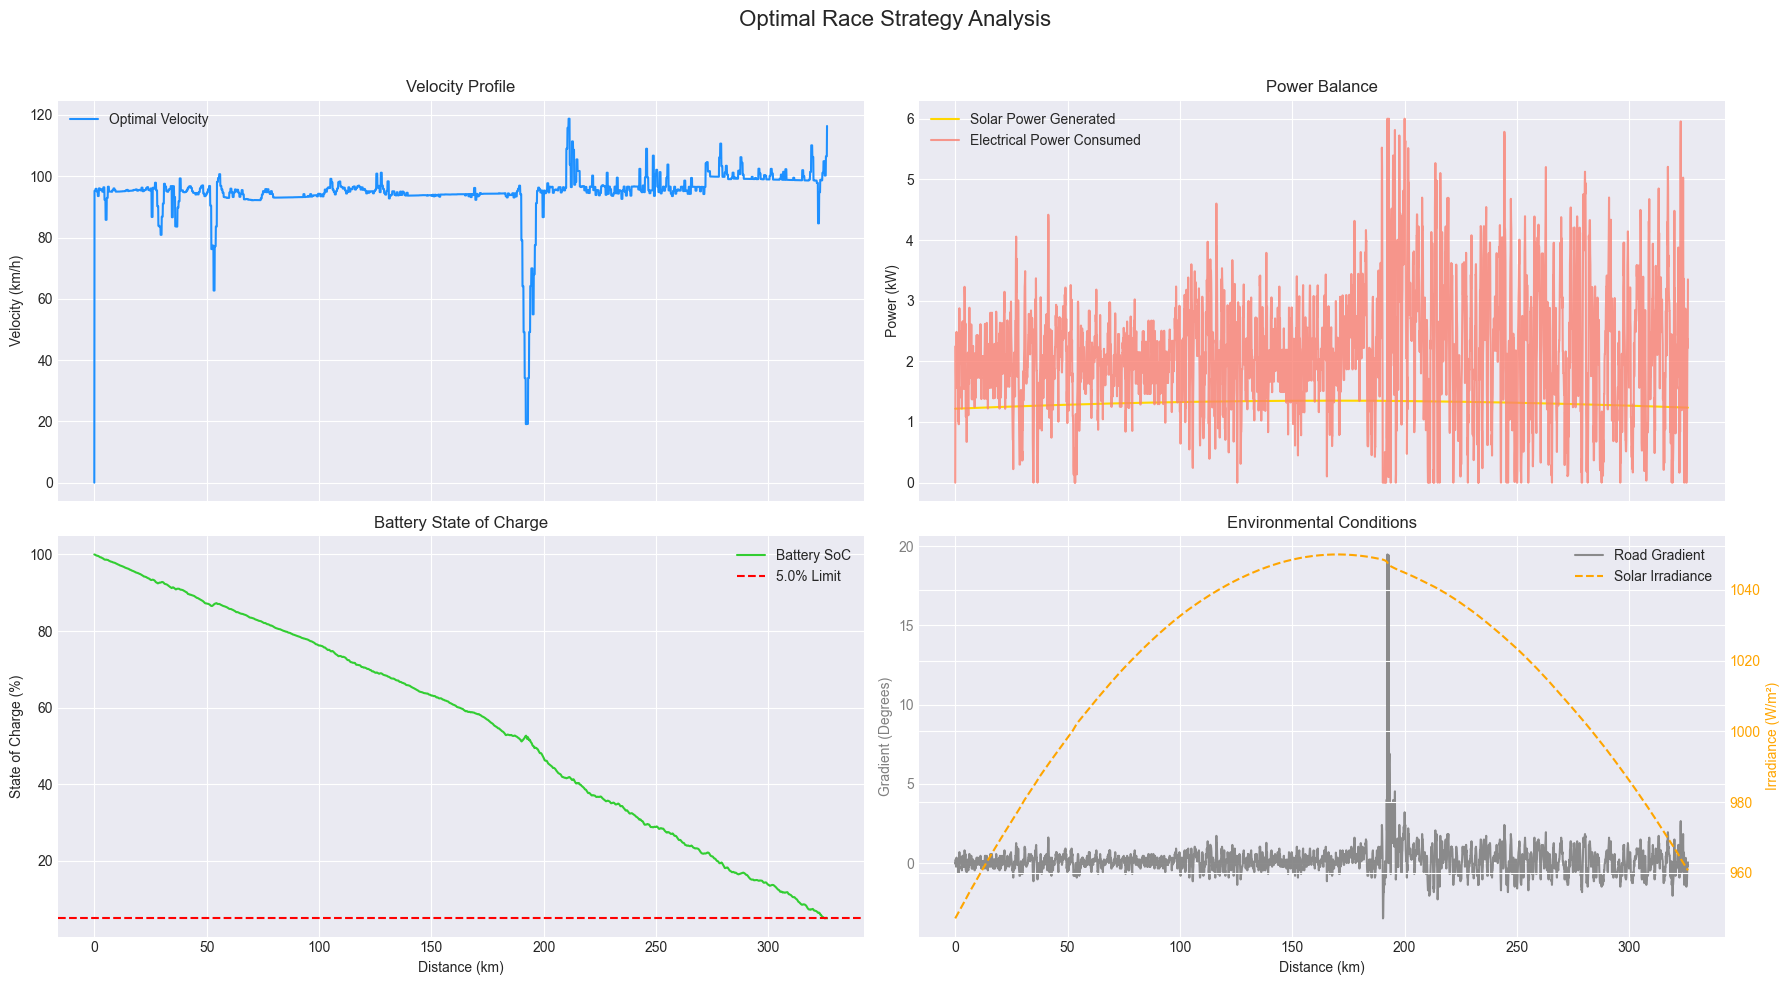

In [11]:
# (env) PS C:\Users\Aurovind Sadangi\Desktop\AgniRath_section5> python .\Agnirath_app\question3.py
# Cleaned route data: Removed 0 duplicate GPS points.
# --- AgniRath Race Strategy Optimization ---
# Route distance: 326.1 km
# Optimizing 653 velocity chunks + 1 start time variable.

# Starting optimization with enhanced debugging...
#   ... Iteration 5/50 complete.
#      Current constraint violation: 40898999933.208038
#   ... Iteration 10/50 complete.
#      Current constraint violation: 0.021919
#      Worst violation: Battery Current Violation - -0.0219
#   ... Iteration 15/50 complete.
#      Current constraint violation: 0.003961
#   ... Iteration 20/50 complete.
#      Current constraint violation: 0.000083
#      Worst violation: Battery Current Violation - -0.0000
#   ... Iteration 25/50 complete.
#      Current constraint violation: 0.000132
#   ... Iteration 30/50 complete.
#      Current constraint violation: 0.000121
#      Worst violation: Minimum SOC Violation - -0.0001
#   ... Iteration 35/50 complete.
#      Current constraint violation: 0.000178
#   ... Iteration 40/50 complete.
#      Current constraint violation: 0.000761
#      Worst violation: Minimum SOC Violation - -0.0003
#   ... Iteration 45/50 complete.
#      Current constraint violation: 0.000561
#   ... Iteration 50/50 complete.
#      Current constraint violation: 0.000038
#      Worst violation: Battery Current Violation - -0.0000
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12572.15065007467
#             Iterations: 50
#             Function evaluations: 33411
#             Gradient evaluations: 51
# Optimization finished in 87.68 seconds.

# ================================================================================
# COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS
# ================================================================================

# Optimization status: Iteration limit reached
# Final function value: 12572.15
# Iterations: 50
# Constraint violation: 0.000000

# Best solution found (violation: 0.000000):
#   Start hour: 10.31
#   Velocities: [ 95.2  95.9  95.   93.5  96.   95.5  95.8  95.   96.4  92.3  85.8  92.9
#   96.6  95.   95.   94.9  95.4  96.   95.4  95.   95.   95.   95.   95.
#   95.1  95.1  95.1  95.1  95.4  95.5  95.2  95.2  95.3  95.3  95.3  95.5
#   95.5  95.7  95.3  95.5  95.6  95.4  96.3  95.1  95.4  95.5  96.1  96.4
#   95.5  95.4  96.   86.7  96.2  95.9  97.9  95.4  90.2  83.8  83.5  80.9
#   86.8  91.1  97.5  96.6  95.1  94.9  95.6  95.9  96.8  86.6  96.8  93.2
#   83.6  83.6  89.7  91.9  99.3  95.3  95.4  94.8  94.8  94.9  95.3  96.
#   96.6  96.7  96.2  95.1  94.6  94.5  94.   94.5  94.1  94.8  96.   96.7
#   97.   94.4  93.5  94.   94.7  95.7  96.8  90.4  76.2  77.4  62.7  77.1
#   83.6  98.2  99.4 100.7  96.9  95.7  94.6  93.2  93.1  93.1  92.9  92.9
#   94.7  96.   94.7  93.2  94.7  95.7  95.   95.6  94.6  93.3  94.2  95.5
#   94.1  92.5  92.5  92.6  92.5  92.3  92.3  92.3  92.2  92.2  92.2  92.3
#   92.3  92.2  92.2  92.2  92.8  94.   95.1  94.8  95.8  94.8  95.8  94.8
#   94.2  95.1  94.2  93.1  93.   93.   93.   93.   93.   93.   93.   93.1
#   93.1  93.1  93.1  93.1  93.1  93.1  93.1  93.1  93.1  93.1  93.1  93.2
#   93.2  93.2  93.2  93.2  93.2  93.2  94.2  93.2  93.3  93.3  93.6  93.3
#   94.2  93.4  93.6  93.8  93.8  93.8  93.4  94.3  94.3  93.5  94.1  93.4
#   94.3  95.7  95.   96.   96.4  96.2  99.2  98.   95.7  94.9  94.1  95.1
#   96.   98.1  98.3  96.6  96.5  96.   96.3  95.4  94.4  94.9  96.4  95.
#   95.9  95.8  96.5  96.7  95.7  96.1  96.7  96.9  96.5  95.7  96.4  95.6
#   95.9  95.3  94.4  95.1  94.6  95.1  95.   95.1  94.4  95.1  95.6 100.8
#   96.3  96.9  94.8 101.2  97.   95.8  94.5  94.   95.2  98.3  92.8  93.6
#   94.   95.1  95.1  93.9  93.8  94.8  93.8  93.9  95.   93.9  95.   94.6
#   93.8  93.7  94.6  93.7  93.7  93.7  93.7  93.7  93.7  93.7  93.7  93.7
#   93.7  93.8  93.8  93.8  93.8  93.8  93.8  93.8  93.7  93.8  93.8  93.8
#   93.6  93.9  93.4  94.   93.7  93.7  94.   93.3  94.   94.1  94.   94.
#   94.1  94.1  94.1  94.   94.   94.1  94.1  94.1  94.1  94.1  94.1  94.1
#   94.1  94.1  94.1  94.1  94.1  94.1  93.7  94.2  94.1  93.5  94.2  93.2
#   94.2  93.9  96.2  92.3  94.2  93.4  93.8  94.5  94.2  94.2  94.3  94.3
#   94.3  94.3  94.3  94.3  94.3  94.3  94.3  94.3  94.3  94.3  94.3  94.3
#   94.4  94.4  94.3  94.3  94.4  94.4  93.5  93.1  94.4  93.8  94.   93.9
#   94.5  93.1  94.4  93.4  95.1  95.9  96.9  94.1  79.1  64.1  49.1  34.1
#   19.1  19.2  34.2  49.2  64.2  69.9  54.9  68.   77.5  91.2  95.2  96.3
#   95.7  94.7  95.3  86.7  95.3  94.5  95.2  97.7  94.7  96.6  96.4  96.6
#   94.6  95.4  95.7  95.6  95.4  96.4  96.4  94.7  95.4  96.4  95.4  96.2
#  109.  115.8 118.8 103.8  96.5 111.4 108.6  97.2  98.2 105.5 101.7 101.7
#   96.6  96.5  96.8  96.8  95.4  96.5  94.6  95.5  94.5  96.6  96.5 100.2
#   95.5  96.5  93.9  95.5  95.4  93.8  94.5  96.7  97.1  96.8  96.6  93.9
#  101.2  94.3  96.6  95.8  93.8  93.6  94.4  96.6  94.4  99.5  94.3  95.4
#   95.2  92.6  95.4  96.6  94.9  93.7  96.6  96.6  95.4  93.7  96.6  96.6
#   96.7  96.6  96.6  96.6  95.7 102.4  95.4  94.8  97.   94.8  99.6 109.
#   99.6  95.4  94.5  95.4  95.4 106.7  93.6 100.5 102.1  96.6  94.8 101.3
#   94.4  95.4  96.6  95.3  96.6  99.5 103.8  95.4  96.6  94.3  93.5  95.2
#   96.6  94.3  95.3  95.7  95.3  95.3  96.6  96.6  95.1  98.6  95.2  95.3
#   94.3  96.6  94.3  99.4  96.6  96.5  96.5  95.3  96.5  96.5  96.5  95.1
#   96.5  96.5  94.2  96.5 104.2 104.6 101.5 101.7  99.9  99.9  99.9  99.9
#   99.9  99.8  99.8  99.8 106.2 110.7 103.3  99.8  99.8 101.2 103.4 100.5
#   99.1  99.1  99.1  99.5 101.2  99.2  99.6  99.2  99.2 101.8 100.7 106.2
#  104.4 100.5  99.2  99.1  99.1  99.1  99.1  99.1  99.1  99.8  99.1  99.1
#   99.5  99.1  99.1 102.5 100.9  99.1  99.   99.  100.4 100.2  99.   99.
#   99.  100.1 102.4 100.9  98.9  98.9  98.9  98.9  98.9  98.9  99.2 100.5
#   98.9 101.4  98.8 102.3  98.8  98.8  98.8  98.8  98.8  98.8  99.5  98.7
#   98.7  98.8  98.7  98.7  98.7  98.7 102.  100.   98.7  98.6  98.6  98.6
#   98.9 101.4 110.1 106.3  98.7  98.6  98.6  97.8  84.6  94.8  98.8  98.7
#  101.1 104.9 100.2 106.5 116.4]

# DETAILED SIMULATION ANALYSIS:
#   Race time: 3.50 hours
#   Min SOC: 5.0% (limit: 5.0%)
#   Max SOC: 100.0% (limit: 102.0%)
#   Max battery current: 50.0A (limit: 50.0A)
#   Average velocity: 94.8 km/h

# ⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 10:18
# Minimized Race Time: 3.50 hours
# Total Solar Energy Generated: 4.58 kWh
# Total Electrical Energy Consumed: 7.43 kWh
# Final Battery Level: 5.0% (0.15 kWh) 
# ==


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.05,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 15.0,
        "max_deceleration_kph_per_chunk": 15.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
# def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
#     """
#     Takes a small array of velocities and maps them to the full route.
#     For example, chunk_velocities[0] applies to the first 2km of the race.
#     """
#     # Get the cumulative distance for each high-resolution segment
#     cumulative_dist = route_df['cumulative_distance_m'].values
    
#     # Determine which chunk each segment belongs to by its distance
#     # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
#     segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
#     # The last index might be out of bounds if the total distance isn't a perfect
#     # multiple of the chunk size, so we clip it to the last valid index.
#     segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
#     # Use the indices to create the full-length velocity profile from the chunk velocities
#     full_velocity_profile = chunk_velocities[segment_chunk_indices]
#     return full_velocity_profile

def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# ==============================================================================
# IMPROVED MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 500
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 10.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 50
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

In [ ]:
# Optimization finished in 66.06 seconds.

# ================================================================================
# COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS
# ================================================================================

# Optimization status: Iteration limit reached
# Final function value: 12470.30
# Iterations: 50
# Constraint violation: 0.000000

# Best solution found (violation: 0.000000):
#   Start hour: 10.44
#   Velocities: [ 93.4  93.3  93.   92.6  93.4  93.5  93.4  93.4  93.4  93.8  93.   93.8
#   93.5  93.5  93.6  93.5  93.5  94.2  93.6  93.6  93.6  93.6  93.6  93.7
#   93.6  93.6  93.6  93.7  93.6  94.7  93.6  93.6  93.6  93.7  93.7  93.7
#   93.6  93.6  93.8  95.   93.7  93.6  93.7  93.7  95.1  93.7  93.7  93.7
#   93.7  93.7  95.3  89.6  95.3  93.7  93.7  93.9  94.8  95.1  95.   96.7
#   94.7  94.1  93.8  93.8  93.9  93.9  93.9  93.9  95.6  92.4  95.6  94.2
#   95.4  97.5  94.7  95.6  95.6  95.2  94.1  93.5  93.4  93.4  94.8  94.8
#   94.9  91.3  94.   94.9  93.4  93.4  93.4  94.5  93.4  93.4  93.6  93.4
#   93.3  93.4  92.6  94.7  94.6  93.4  93.3  93.8  73.5  93.6  63.6  86.
#   89.8  91.1  92.1  91.3  93.6  93.7  93.7  93.7  93.7  93.6  93.6  93.5
#   93.5  94.5  93.5  93.4  93.4  94.1  89.6  94.6  93.3  93.3  93.3  94.6
#   93.6  93.7  93.5  93.5  93.4  93.4  93.3  93.3  93.2  93.2  93.1  93.
#   93.   93.   92.9  92.8  92.8  92.8  94.5  88.   94.5  93.4  92.3  93.4
#   93.4  91.2  93.7  92.9  92.8  92.7  92.7  92.6  92.6  92.5  92.4  92.4
#   92.4  92.4  92.4  92.4  92.4  92.4  92.3  92.2  92.2  92.1  92.2  92.2
#   92.2  92.1  92.1  92.1  92.1  92.1  95.1  92.   92.   91.9  92.5  92.5
#   95.1  92.6  92.6  92.6  92.7  92.7  92.6  95.   95.   92.4  92.7  93.
#   95.   95.   92.9  95.   89.1  95.  101.7  86.4  94.8  93.1  93.1  93.1
#   93.1  92.2  91.4  78.9 101.7  87.1  94.7  92.4  92.4  93.   95.5  93.
#   94.3  92.9  94.5  93.9  92.9  94.3  94.3  91.3  93.9  92.8  94.6  93.2
#   92.7  93.2  92.7  93.8  92.7  94.   92.6  94.   92.7  93.   93.8 100.9
#   93.7  90.1 106.6  85.1  93.4  93.3  93.5  93.3  94.3  91.2  93.5  93.6
#   93.6  94.2  94.2  93.7  93.7  94.2  93.8  93.9  94.1  93.9  94.1  94.1
#   95.4  95.3  94.1  94.   94.1  94.1  94.2  94.2  94.3  94.4  94.4  94.5
#   94.6  94.7  94.7  94.8  94.9  95.   95.   95.   93.9  95.   95.   95.1
#   94.5  95.3  93.9  95.3  94.6  94.8  95.3  93.2  95.4  95.6  95.5  95.4
#   95.6  95.6  95.7  95.5  95.5  95.5  95.6  95.5  95.6  95.6  95.6  95.7
#   95.6  95.6  95.7  95.7  95.7  95.7  94.9  95.8  95.8  94.3  95.8  92.9
#   95.8  95.8  91.3  96.3  96.   94.3  95.1  96.5  96.   96.   96.1  96.
#   96.1  96.   96.1  96.1  96.1  96.1  96.1  96.   96.1  96.1  96.1  96.2
#   96.4  96.2  96.2  96.2  96.3  95.4  94.6  92.9  96.3  95.6  91.   95.8
#   96.4  92.9  96.3  96.4  96.4  96.4  96.4  97.2 116.6 108.7  78.7  49.1
#   19.1  19.2  49.2  62.9  77.3  74.8  96.7  69.8  94.9  97.3  96.3  95.7
#   97.   99.   96.9  85.4  95.8  98.   95.6  97.3  99.1  99.3  99.1  97.3
#   95.8  97.9  96.7  96.7  98.1  99.1  99.1  94.6  97.3  99.1  97.9  99.1
#  108.5 115.5 119.1  99.1  96.4 108.9 107.5  95.9  98.5 115.   96.7 103.9
#   96.4  97.   99.5  96.1  97.9  96.4  94.6  95.9  96.8  99.4  99.2  98.1
#   98.   99.2  99.1  93.4  97.9  95.6  96.7  99.4  99.9  99.6  95.5  96.8
#  100.3  96.9  99.3  97.2  95.6  91.9  97.4  99.2  98.2 100.9  97.   97.3
#   91.8  97.9  97.2  99.2  94.8  95.4  95.3  96.3  97.8  95.3  99.2  99.2
#   99.3  95.1  99.2  99.2  97.1 104.9  97.4  92.8  92.6  96.6 100.8 106.4
#   97.6  97.8  93.9  97.8  97.8 102.2  95.3  98.3 103.   99.2  97.6  96.9
#   97.8  97.8  96.4  95.4  99.2  97.5 104.5  97.8  99.1  96.4  95.2  95.3
#   96.3  96.4  97.8  96.4  97.7  97.7  96.3  96.3  99.1  96.6  99.1  97.7
#   96.3  99.   96.3  97.4  96.3  99.   99.   97.6  99.   99.   96.3  95.
#   99.   99.   96.2  99.  103.4 104.   99.7  99.6  99.6  99.6  99.6  99.6
#   99.6  99.5  99.5  99.5  99.2 114.   99.5  99.5  99.5 100.7 103.9  99.9
#   99.4  99.4  99.4  99.5 100.5  99.4  99.4  99.4  99.4 101.  100.  104.8
#  102.5  99.9  99.3  99.3  99.3  99.3  99.3  99.3  99.3  99.4  99.2  99.2
#   99.2  99.2  99.2 105.7 100.1  98.7  99.2  99.1  99.7  99.3  99.1  99.1
#   99.1  99.3 101.  100.2  99.1  99.   99.   99.   99.   99.   99.   99.2
#   98.9 100.6  98.9 101.6  98.7  98.9  98.9  98.9  98.9  98.9  99.   98.9
#   98.9  98.9  98.8  98.8  98.8  98.8 100.9  99.3  98.8  98.8  98.7  98.7
#   98.7 101.4 115.5  99.3  98.8  98.7  98.7  97.7  98.7  80.1  99.1  98.8
#  101.2 101.9  92.  115.9 123.4]

# DETAILED SIMULATION ANALYSIS:
#   Race time: 3.47 hours
#   Min SOC: 3.0% (limit: 3.0%)
#   Max SOC: 100.0% (limit: 102.0%)
#   Max battery current: 50.0A (limit: 50.0A)
#   Average velocity: 95.2 km/h

# ⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 10:26
# Minimized Race Time: 3.47 hours
# Total Solar Energy Generated: 4.55 kWh
# Total Electrical Energy Consumed: 7.46 kWh
# Final Battery Level: 3.0% (0.09 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 30.0,
        "max_deceleration_kph_per_chunk": 30.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='Agnirath_app/route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
# def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
#     """
#     Takes a small array of velocities and maps them to the full route.
#     For example, chunk_velocities[0] applies to the first 2km of the race.
#     """
#     # Get the cumulative distance for each high-resolution segment
#     cumulative_dist = route_df['cumulative_distance_m'].values
    
#     # Determine which chunk each segment belongs to by its distance
#     # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
#     segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
#     # The last index might be out of bounds if the total distance isn't a perfect
#     # multiple of the chunk size, so we clip it to the last valid index.
#     segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
#     # Use the indices to create the full-length velocity profile from the chunk velocities
#     full_velocity_profile = chunk_velocities[segment_chunk_indices]
#     return full_velocity_profile

def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# ==============================================================================
# IMPROVED MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 500
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 10.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 50
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 1631 velocity chunks + 1 start time variable.

Starting optimization with enhanced debugging...
  ... Iteration 5/50 complete.
     Current constraint violation: 2.985754
  ... Iteration 10/50 complete.
     Current constraint violation: 0.070419
     Worst violation: Battery Current Violation - -0.0072
  ... Iteration 15/50 complete.
     Current constraint violation: 0.000244
  ... Iteration 20/50 complete.
     Current constraint violation: 0.004598
     Worst violation: Battery Current Violation - -0.0043
  ... Iteration 25/50 complete.
     Current constraint violation: 0.000000
  ... Iteration 30/50 complete.
     Current constraint violation: 0.000370
     Worst violation: Battery Current Violation - -0.0002
  ... Iteration 35/50 complete.
     Current constraint violation: 0.003124
  ... Iteration 40/50 complete.
     Current constraint violation: 

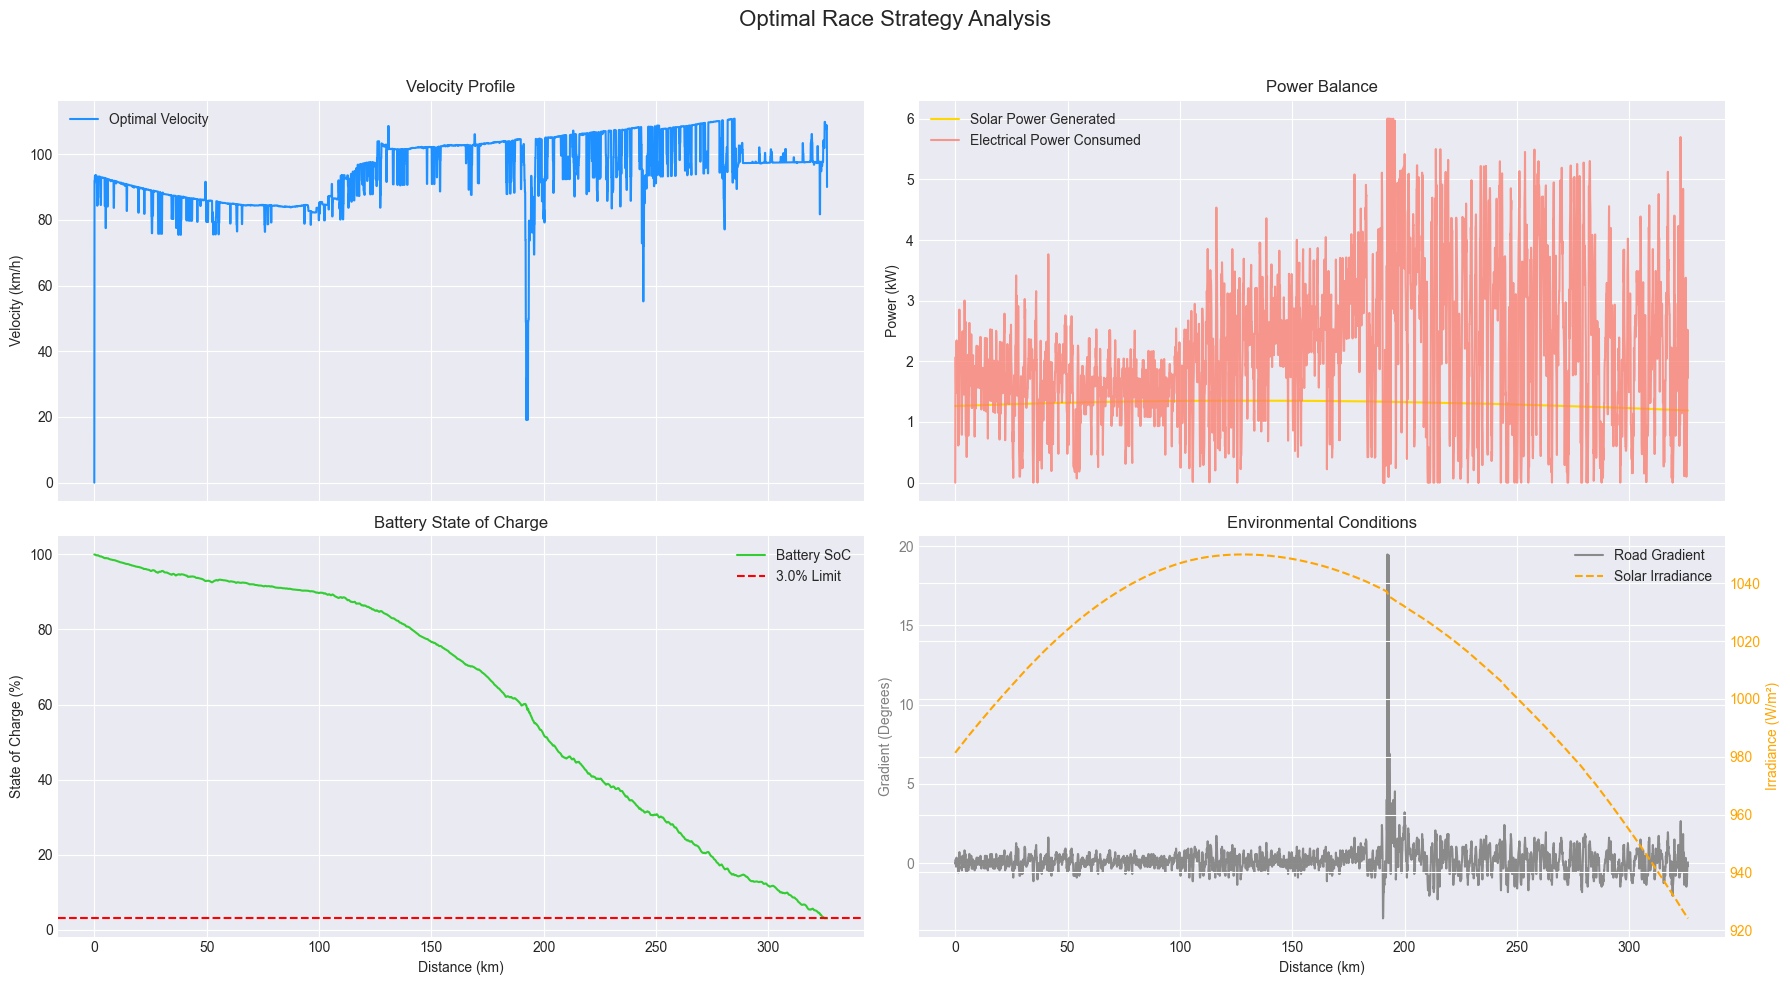

In [ ]:
# Cleaned route data: Removed 0 duplicate GPS points.
# --- AgniRath Race Strategy Optimization ---
# Route distance: 326.1 km
# Optimizing 1631 velocity chunks + 1 start time variable.

# Starting optimization with enhanced debugging...
#   ... Iteration 5/50 complete.
#      Current constraint violation: 2.985754
#   ... Iteration 10/50 complete.
#      Current constraint violation: 0.070419
#      Worst violation: Battery Current Violation - -0.0072
#   ... Iteration 15/50 complete.
#      Current constraint violation: 0.000244
#   ... Iteration 20/50 complete.
#      Current constraint violation: 0.004598
#      Worst violation: Battery Current Violation - -0.0043
#   ... Iteration 25/50 complete.
#      Current constraint violation: 0.000000
#   ... Iteration 30/50 complete.
#      Current constraint violation: 0.000370
#      Worst violation: Battery Current Violation - -0.0002
#   ... Iteration 35/50 complete.
#      Current constraint violation: 0.003124
#   ... Iteration 40/50 complete.
#      Current constraint violation: 0.000654
#      Worst violation: Battery Current Violation - -0.0005
#   ... Iteration 45/50 complete.
#      Current constraint violation: 0.023110
#   ... Iteration 50/50 complete.
#      Current constraint violation: 0.001059
#      Worst violation: Battery Current Violation - -0.0006
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12445.956413774766
#             Iterations: 50
#             Function evaluations: 83283
#             Gradient evaluations: 51
# Optimization finished in 324.99 seconds.

# ================================================================================
# COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS
# ================================================================================

# Optimization status: Iteration limit reached
# Final function value: 12445.96
# Iterations: 50
# Constraint violation: 0.000000

# Best solution found (violation: 0.000000):
#   Start hour: 10.65
#   Velocities: [ 91.8  93.6  93.4 ... 107.7 108.8  90. ]

# CONSTRAINT VIOLATIONS IN BEST SOLUTION:
#   1. Battery Current Violation: Current exceeds 50.0A (limit: 50.0A)

# DETAILED SIMULATION ANALYSIS:
#   Race time: 3.48 hours
#   Min SOC: 3.0% (limit: 3.0%)
#   Max SOC: 100.0% (limit: 102.0%)
#   Max battery current: 50.0A (limit: 50.0A)
#   Average velocity: 95.0 km/h
#   ❌ Current violation at segment 1947, distance: 193.9km

# ⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 10:38
# Minimized Race Time: 3.48 hours
# Total Solar Energy Generated: 4.55 kWh
# Total Electrical Energy Consumed: 7.46 kWh
# Final Battery Level: 3.0% (0.09 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 30.0,
        "max_deceleration_kph_per_chunk": 30.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
# def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
#     """
#     Takes a small array of velocities and maps them to the full route.
#     For example, chunk_velocities[0] applies to the first 2km of the race.
#     """
#     # Get the cumulative distance for each high-resolution segment
#     cumulative_dist = route_df['cumulative_distance_m'].values
    
#     # Determine which chunk each segment belongs to by its distance
#     # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
#     segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
#     # The last index might be out of bounds if the total distance isn't a perfect
#     # multiple of the chunk size, so we clip it to the last valid index.
#     segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
#     # Use the indices to create the full-length velocity profile from the chunk velocities
#     full_velocity_profile = chunk_velocities[segment_chunk_indices]
#     return full_velocity_profile

def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# ==============================================================================
# IMPROVED MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 200
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 10.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 50
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 1631 velocity chunks + 1 start time variable.

Starting optimization with enhanced debugging...
  ... Iteration 5/100 complete.
     Current constraint violation: 0.002022
  ... Iteration 10/100 complete.
     Current constraint violation: 0.024115
     Worst violation: Minimum SOC Violation - -0.0031
  ... Iteration 15/100 complete.
     Current constraint violation: 0.000460
  ... Iteration 20/100 complete.
     Current constraint violation: 0.000118
     Worst violation: Minimum SOC Violation - -0.0001
  ... Iteration 25/100 complete.
     Current constraint violation: 0.000040
  ... Iteration 30/100 complete.
     Current constraint violation: 0.010641
     Worst violation: Battery Current Violation - -0.0106
  ... Iteration 35/100 complete.
     Current constraint violation: 0.000002
  ... Iteration 40/100 complete.
     Current constraint violation: 

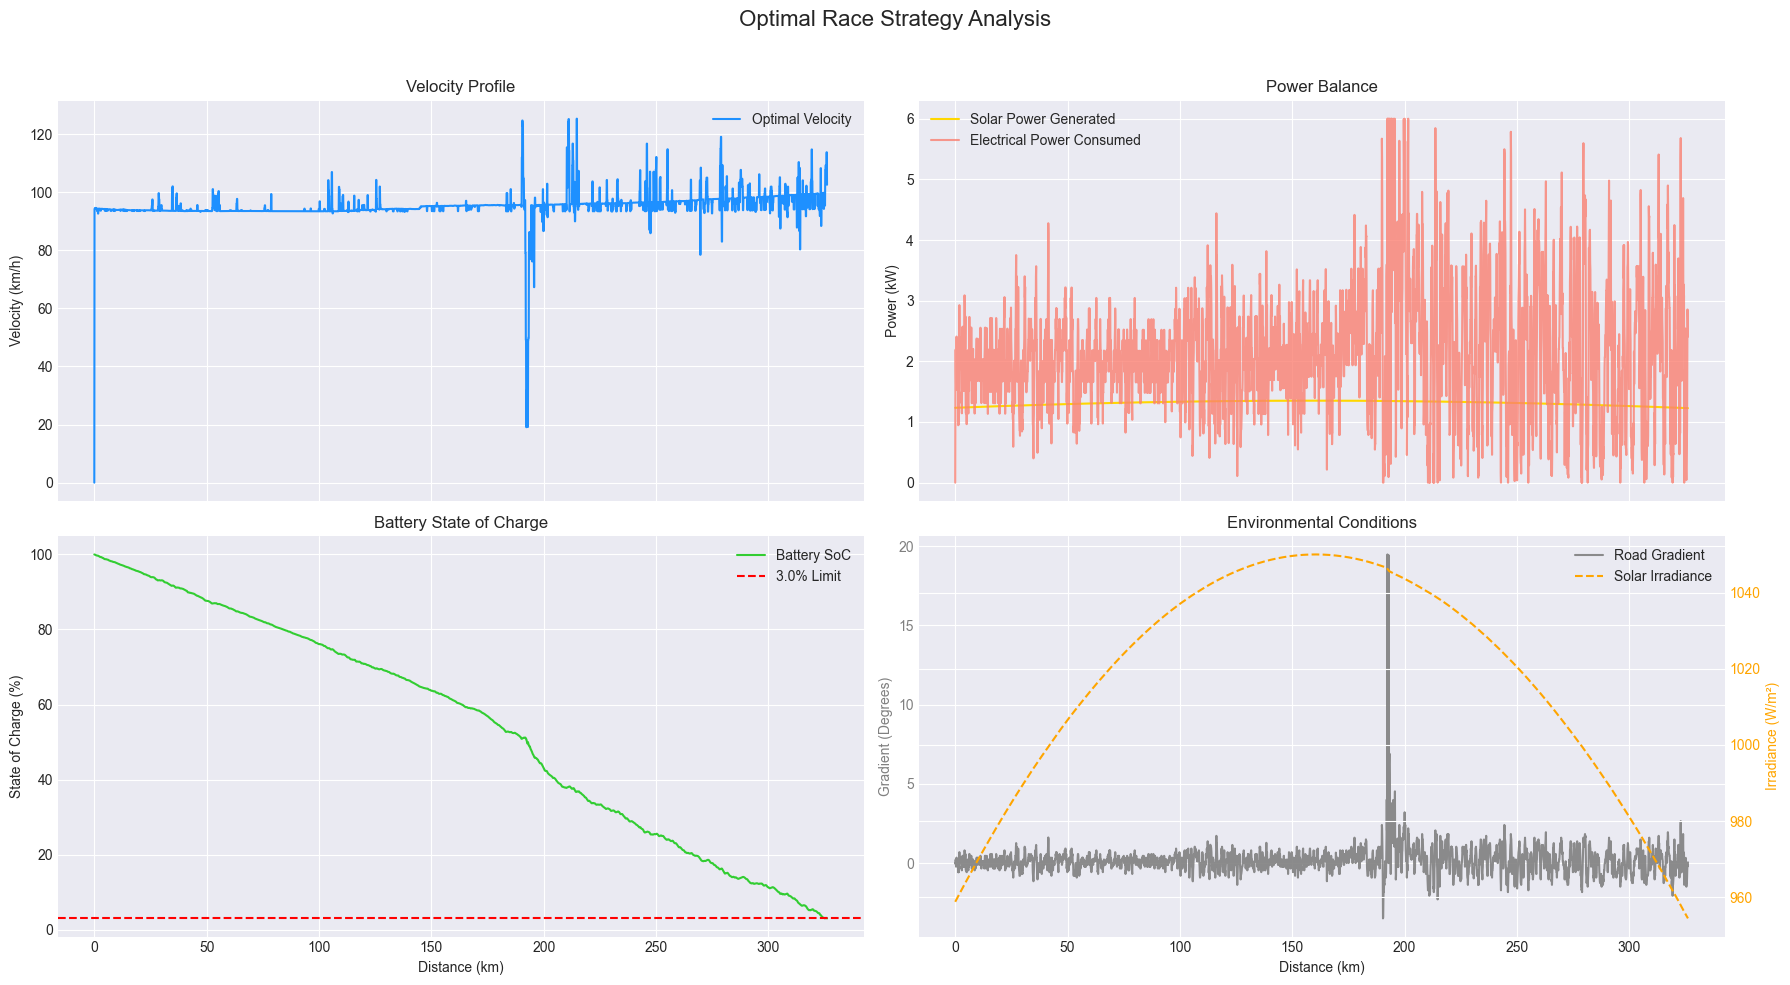

In [15]:
# Cleaned route data: Removed 0 duplicate GPS points.
# --- AgniRath Race Strategy Optimization ---
# Route distance: 326.1 km
# Optimizing 1631 velocity chunks + 1 start time variable.

# Starting optimization with enhanced debugging...
#   ... Iteration 5/100 complete.
#      Current constraint violation: 0.002022
#   ... Iteration 10/100 complete.
#      Current constraint violation: 0.024115
#      Worst violation: Minimum SOC Violation - -0.0031
#   ... Iteration 15/100 complete.
#      Current constraint violation: 0.000460
#   ... Iteration 20/100 complete.
#      Current constraint violation: 0.000118
#      Worst violation: Minimum SOC Violation - -0.0001
#   ... Iteration 25/100 complete.
#      Current constraint violation: 0.000040
#   ... Iteration 30/100 complete.
#      Current constraint violation: 0.010641
#      Worst violation: Battery Current Violation - -0.0106
#   ... Iteration 35/100 complete.
#      Current constraint violation: 0.000002
#   ... Iteration 40/100 complete.
#      Current constraint violation: 0.000016
#      Worst violation: Battery Current Violation - -0.0000
#   ... Iteration 45/100 complete.
#      Current constraint violation: 0.000018
#   ... Iteration 50/100 complete.
#      Current constraint violation: 0.000747
#      Worst violation: Battery Current Violation - -0.0007
#   ... Iteration 55/100 complete.
#      Current constraint violation: 0.000036
#   ... Iteration 60/100 complete.
#      Current constraint violation: 0.000034
#      Worst violation: Battery Current Violation - -0.0000
#   ... Iteration 65/100 complete.
#      Current constraint violation: 0.000090
#   ... Iteration 70/100 complete.
#      Current constraint violation: 0.000094
#      Worst violation: Battery Current Violation - -0.0001
#   ... Iteration 75/100 complete.
#      Current constraint violation: 0.000082
#   ... Iteration 80/100 complete.
#      Current constraint violation: 0.000052
#      Worst violation: Battery Current Violation - -0.0000
#   ... Iteration 85/100 complete.
#      Current constraint violation: 0.000066
#   ... Iteration 90/100 complete.
#      Current constraint violation: 0.000041
#      Worst violation: Battery Current Violation - -0.0000
#   ... Iteration 95/100 complete.
#      Current constraint violation: 0.000020
#   ... Iteration 100/100 complete.
#      Current constraint violation: 0.000160
#      Worst violation: Battery Current Violation - -0.0000
# Iteration limit reached    (Exit mode 9)
#             Current function value: 12403.787079766558
#             Iterations: 100
#             Function evaluations: 164939
#             Gradient evaluations: 101
# Optimization finished in 335.32 seconds.

# ================================================================================
# COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS
# ================================================================================

# Optimization status: Iteration limit reached
# Final function value: 12403.79
# Iterations: 100
# Constraint violation: 0.000002

# Best solution found (violation: 0.000002):
#   Start hour: 10.42
#   Velocities: [ 94.2  94.6  94.6 ... 105.3 113.8 102.6]

# CONSTRAINT VIOLATIONS IN BEST SOLUTION:
#   1. Battery Current Violation: Current exceeds 50.0A (limit: 50.0A)

# DETAILED SIMULATION ANALYSIS:
#   Race time: 3.45 hours
#   Min SOC: 3.0% (limit: 3.0%)
#   Max SOC: 100.0% (limit: 102.0%)
#   Max battery current: 50.0A (limit: 50.0A)
#   Average velocity: 95.2 km/h
#   ❌ Current violation at segment 1929, distance: 192.3km

# ⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---
# Optimal Race Start Time: 10:25
# Minimized Race Time: 3.45 hours
# Total Solar Energy Generated: 4.52 kWh
# Total Electrical Energy Consumed: 7.43 kWh
# Final Battery Level: 3.0% (0.09 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

# def get_vehicle_parameters():
#     """Returns a dictionary of all vehicle and environmental constants."""
#     return {
#         # Vehicle Parameters
#         "vehicle_mass": 250.0,  # kg (car + driver)
#         "drag_area_CdA": 0.12,  # m^2 (Cd * Frontal Area)
#         "coeff_rolling_resistance_Crr": 0.006,
#         "drivetrain_efficiency": 0.97,  # Motor, controller, and gearbox
        
#         # Battery
#         "battery_capacity_joules": 5 * 3.6e6,  # 5 kWh converted to Joules
#         "initial_SoC": 1.0,  # Start with a full battery (100%)
#         "min_SoC": 0.0,      # Minimum allowed SoC

#         # Solar Array
#         "solar_panel_area": 4.0,       # m^2
#         "solar_panel_efficiency": 0.24,  # 24%

#         # Environmental Constants
#         "air_density": 1.225,  # kg/m^3
#         "gravity": 9.81,       # m/s^2
#     }

# REPLACE your get_vehicle_parameters function with this
# REPLACE your get_vehicle_parameters function with this new version
def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 30.0,
        "max_deceleration_kph_per_chunk": 30.0,
    }

# def get_real_solar_data(latitude, longitude, start_date, end_date, cache_filename="solar_data_cache.csv"):
#     """
#     Fetches historical solar irradiance data, using a local cache to avoid repeated API calls.
#     """
#     try:
#         df = pd.read_csv(cache_filename, index_col='time', parse_dates=True)
#         print("Loaded solar data from local cache.")
#         return df
#     except FileNotFoundError:
#         print(f"Cache not found. Fetching real solar data from Open-Meteo API for {start_date}...")
#         url = "https://archive-api.open-meteo.com/v1/archive"
#         params = {
#             "latitude": latitude,
#             "longitude": longitude,
#             "start_date": start_date,
#             "end_date": end_date,
#             "hourly": "shortwave_radiation",
#             "timezone": "Asia/Kolkata"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             df = pd.DataFrame(data['hourly'])
            
#             # --- THIS IS THE CRUCIAL FIX ---
#             # Ensure the radiation column is numeric, coercing errors to NaN, then fill NaNs with 0.0
#             df['shortwave_radiation'] = pd.to_numeric(df['shortwave_radiation'], errors='coerce').fillna(0.0)
            
#             df['time'] = pd.to_datetime(df['time'])
#             print("Successfully fetched and cleaned solar data.")
#             df.to_csv(cache_filename)
#             return df.set_index('time')
#         else:
#             print(f"Failed to fetch solar data. Status code: {response.status_code}")
#             return None
        
# # ADD THIS NEW FUNCTION
# def create_solar_irradiance_interpolator(solar_df):
#     """
#     Creates a function that can estimate solar irradiance at any time of day
#     by interpolating the hourly data from the API.
#     """
#     # Convert the datetime index to hours from the beginning of the day (0.0 to 23.99)
#     time_hours = solar_df.index.hour + solar_df.index.minute / 60.0
#     irradiance_values = solar_df['shortwave_radiation'].values
    
#     # np.interp is a highly efficient way to perform linear interpolation.
#     # It returns a function-like object we can call later.
#     # We add points for the start and end of the day to ensure we can query any time.
#     full_day_hours = np.insert(time_hours, [0, len(time_hours)], [0.0, 24.0])
#     full_day_irradiance = np.insert(irradiance_values, [0, len(irradiance_values)], [0.0, 0.0])
    
#     # This 'interpolator' is now a callable function
#     solar_interpolator = lambda t: np.interp(t, full_day_hours, full_day_irradiance)
#     return solar_interpolator

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

def get_solar_irradiance(time_of_day_hours, latitude_deg=-23.0):
    """
    A simple clear-sky solar irradiance model.
    Models a single race day (e.g., 8 AM to 5 PM) in Australia.
    Returns an array of irradiances in W/m^2.
    """
    sunrise = 8.0  # 8 AM
    sunset = 17.0  # 5 PM

    # Create a boolean "mask" to identify times that are during the day
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)

    # Calculate the angle for the sinusoidal model
    # The angle is calculated for all times, but we will only use it for daylight hours
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)

    # Calculate the sinusoidal irradiance
    sinusoidal_irradiance = 1000 * np.sin(angle)

    # Use np.where to apply the condition:
    # where daylight_hours is True, use the calculated irradiance, otherwise use 0.0
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)

    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

# def run_race_simulation(velocities_kph, route_df, params):
#     """
#     Simulates the entire race for a given velocity profile.
    
#     Args:
#         velocities_kph (np.array): An array of velocities (km/h) for each segment.
#         route_df (pd.DataFrame): The prepared route data.
#         params (dict): The vehicle parameters.

#     Returns:
#         tuple: (total_time_s, soc_profile, power_profile)
#     """
#     # Convert velocities from km/h to m/s for physics calculations
#     velocities_mps = velocities_kph / 3.6
    
#     # --- Calculate Forces and Power for ALL segments at once (Vectorization) ---
    
#     # Resistive Forces
#     F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
#     F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
#     F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    
#     F_resistive = F_drag + F_rolling + F_gradient
#     # Ensure tractive force is never negative (we use brakes for that, not reverse thrust)
#     F_tractive = np.maximum(0, F_resistive)

#     # Power Calculations
#     P_mech_watts = F_tractive * velocities_mps
#     P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

#     # --- Time and Energy Simulation (Iterative) ---
    
#     segment_distances = route_df['segment_distance_m'].values
#     # Calculate time taken for each segment (delta_t = delta_d / v)
#     # Add a small epsilon to velocity to avoid division by zero
#     delta_t_s = segment_distances / (velocities_mps + 1e-9)
    
#     total_time_s = np.sum(delta_t_s)
    
#     # Calculate time of day for each segment to get solar irradiance
#     time_of_day_hours = 8.0 + np.cumsum(delta_t_s) / 3600.0 # Start race at 8 AM
    
#     P_solar_watts = get_solar_irradiance(time_of_day_hours) * \
#                     params['solar_panel_area'] * \
#                     params['solar_panel_efficiency']
    
#     # Net power flow for each segment (solar generation - electrical consumption)
#     P_net_watts = P_solar_watts - P_elec_watts
    
#     # Calculate energy change in Joules for each segment (delta_E = P * delta_t)
#     delta_energy_joules = P_net_watts * delta_t_s
    
#     # Calculate the battery energy level over the whole race
#     initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
#     cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    
#     # Convert energy profile to State of Charge (SoC) profile
#     soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
#     # Package power data for plotting
#     power_profile = {
#         'solar_gen_W': P_solar_watts,
#         'elec_cons_W': P_elec_watts
#     }
    
#     return total_time_s, soc_profile, power_profile

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# ADD THIS ENTIRE DEBUGGING FUNCTION
def debug_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A special version of the simulation with the final time-wrapping fix included.
    """
    print("\n[DEBUG] Starting detailed simulation trace...")
    
    if check_array("Initial Velocities (kph)", velocities_kph): return
    velocities_mps = velocities_kph / 3.6
    if check_array("Initial Velocities (mps)", velocities_mps): return
    # --- Check Forces ---
    print("\n[DEBUG] Checking Force calculations...")
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    if check_array("Drag Force", F_drag): return
    
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    # F_rolling is a constant, but we can check it
    if check_array("Rolling Resistance Force", np.array([F_rolling])): return

    gradient_array = route_df['gradient_sin_theta'].values
    if check_array("Gradient (sin_theta)", gradient_array): return
    F_gradient = params['vehicle_mass'] * params['gravity'] * gradient_array
    if check_array("Gradient Force", F_gradient): return
    
    F_resistive = F_drag + F_rolling + F_gradient
    if check_array("Total Resistive Force", F_resistive): return
    
    F_tractive = np.maximum(0, F_resistive)
    if check_array("Tractive Force", F_tractive): return

    # --- Check Power ---
    print("\n[DEBUG] Checking Power calculations...")
    P_mech_watts = F_tractive * velocities_mps
    if check_array("Mechanical Power", P_mech_watts): return
    
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']
    if check_array("Electrical Power", P_elec_watts): return

    battery_current_a = P_elec_watts / params['battery_voltage_v']
    if check_array("Battery Current", battery_current_a): return

    # --- Check Time and Energy ---
    print("\n[DEBUG] Checking Time and Energy calculations...")
    segment_distances = route_df['segment_distance_m'].values
    if check_array("Segment Distances", segment_distances): return

    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    if check_array("Delta T (time per segment)", delta_t_s): return

    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    if check_array("Time of Day (hours)", time_of_day_hours): return

    print("\n[DEBUG] Checking Solar calculations...")
    time_of_day_wrapped = time_of_day_hours % 24
    if check_array("Time of Day Wrapped (hours % 24)", time_of_day_wrapped): return
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
    if check_array("Solar Power Generated", P_solar_watts): return
    
    P_net_watts = P_solar_watts - P_elec_watts
    if check_array("Net Power", P_net_watts): return
    
    delta_energy_joules = P_net_watts * delta_t_s
    if check_array("Delta Energy", delta_energy_joules): return

    # --- Check Final SoC ---
    print("\n[DEBUG] Checking final SoC calculation...")
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    if check_array("Cumulative Energy", cumulative_energy_joules): return
    
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    if check_array("SoC Profile", soc_profile): return

    print("\n[DEBUG] All checks passed. No NaN or Inf values detected in the simulation.")

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# In Section 3, ADD THIS NEW CLASS
# class OptimizationCallback:
#     """A simple callback to print progress during optimization."""
#     def __init__(self, max_iterations):
#         self.iteration_count = 0
#         self.max_iterations = max_iterations

#     def __call__(self, xk):
#         """This method is called by the optimizer at each iteration."""
#         self.iteration_count += 1
#         if self.iteration_count % 5 == 0:
#             print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


class OptimizationCallback:
    """
    A callback to print progress and store the last known valid solution.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.last_valid_x = None

    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
        
        # Check if the current solution 'xk' is valid
        constraints = self.constraint_func(xk, *self.constraint_args)
        if np.all(constraints >= 0):
            # If all constraint values are non-negative, the solution is valid
            self.last_valid_x = xk

# ADD THIS NEW HELPER FUNCTION HERE
# def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
#     """
#     Takes a small array of velocities and maps them to the full route.
#     For example, chunk_velocities[0] applies to the first 2km of the race.
#     """
#     # Get the cumulative distance for each high-resolution segment
#     cumulative_dist = route_df['cumulative_distance_m'].values
    
#     # Determine which chunk each segment belongs to by its distance
#     # e.g., a segment at 4500m belongs to chunk index 2 (4500 / 2000 = 2.25 -> 2)
#     segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    
#     # The last index might be out of bounds if the total distance isn't a perfect
#     # multiple of the chunk size, so we clip it to the last valid index.
#     segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
#     # Use the indices to create the full-length velocity profile from the chunk velocities
#     full_velocity_profile = chunk_velocities[segment_chunk_indices]
#     return full_velocity_profile

def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================


# if __name__ == '__main__':
#     # --- Load all data as before ---
#     vehicle_params = get_vehicle_parameters()
#     route_data = load_route_data()
#     solar_df = get_real_solar_data(
#         latitude=12.9, 
#         longitude=79.1,
#         start_date="2025-09-27",
#         end_date="2025-09-27"
#     )
#     if solar_df is None:
#         exit("Could not get solar data. Exiting.")
#     solar_interpolator = create_solar_irradiance_interpolator(solar_df)
    
#     # --- Setup the initial guess for the test ---
#     CHUNK_SIZE_M = 1000
#     num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
#     initial_start_hour = 11.0
#     initial_velocities = np.full(num_chunks, 20.0) # Using your safe 20.0 kph guess
#     initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
#     # --- RUN THE DETAILED DIAGNOSTIC CHECK ---
#     print("\n--- RUNNING DETAILED DIAGNOSTIC ON INITIAL GUESS ---")
    
#     # Unpack the guess into the format the simulation needs
#     start_hour_guess = initial_guess[0]
#     chunk_velocities_guess = initial_guess[1:]
    
#     # Create the full velocity profile from the guess
#     velocities_kph_guess = map_chunk_velocities_to_segments(
#         chunk_velocities_guess, route_data, CHUNK_SIZE_M
#     )
    
#     # Run the debug version of the simulation
#     debug_race_simulation(
#         velocities_kph_guess, route_data, vehicle_params, start_hour_guess, solar_interpolator
#     )
    
#     print("\n--- DIAGNOSTIC CHECK COMPLETE ---")


# ==============================================================================
# IMPROVED MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 200
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 9.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 100
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 1631 velocity chunks + 1 start time variable.

Starting optimization with enhanced debugging...
  ... Iteration 5/100 complete.
     Current constraint violation: 0.002022
  ... Iteration 10/100 complete.
     Current constraint violation: 0.024115
     Worst violation: Minimum SOC Violation - -0.0031
  ... Iteration 15/100 complete.
     Current constraint violation: 0.000460
  ... Iteration 20/100 complete.
     Current constraint violation: 0.000118
     Worst violation: Minimum SOC Violation - -0.0001
  ... Iteration 25/100 complete.
     Current constraint violation: 0.000040
  ... Iteration 30/100 complete.
     Current constraint violation: 0.010641
     Worst violation: Battery Current Violation - -0.0106
  ... Iteration 35/100 complete.
     Current constraint violation: 0.000002
  ... Iteration 40/100 complete.
     Current constraint violation: 

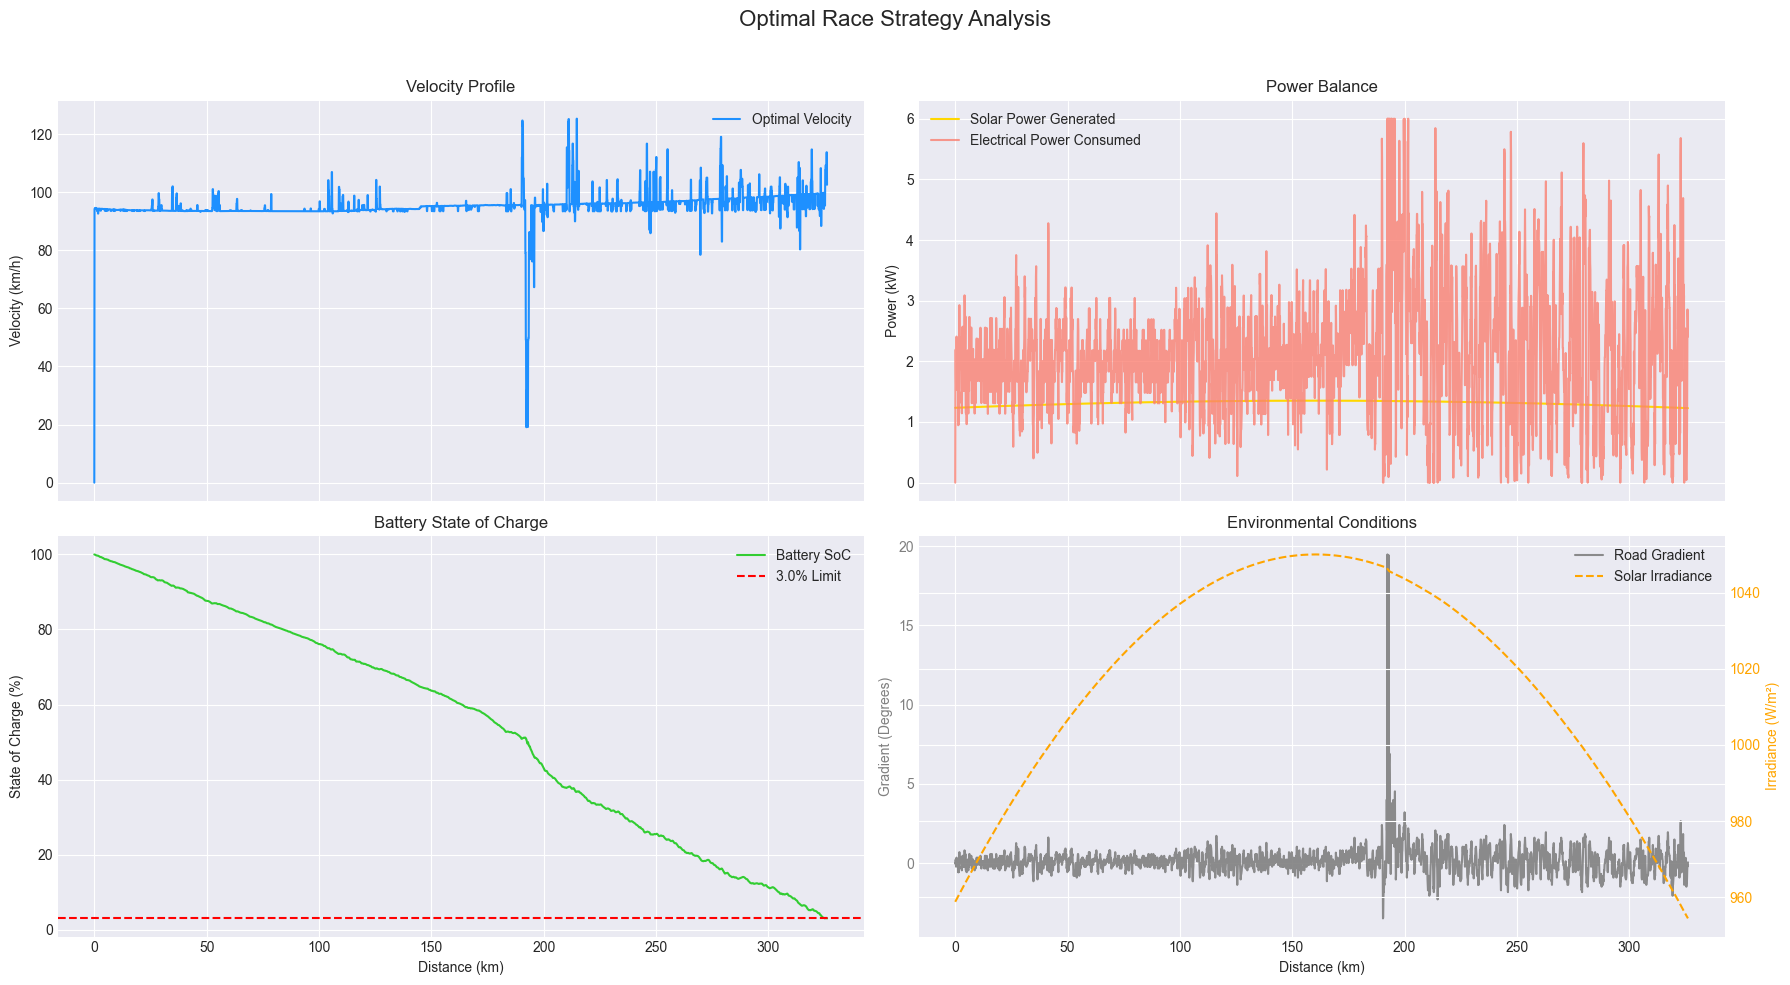

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 30.0,
        "max_deceleration_kph_per_chunk": 30.0,
    }

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 200
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 9.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 100
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 218 velocity chunks + 1 start time variable.

Starting optimization with enhanced debugging...
  ... Iteration 5/100 complete.
     Current constraint violation: 0.186214
  ... Iteration 10/100 complete.
     Current constraint violation: 0.005161
     Worst violation: Minimum SOC Violation - -0.0012
  ... Iteration 15/100 complete.
     Current constraint violation: 0.000536
  ... Iteration 20/100 complete.
     Current constraint violation: 0.000000
     Worst violation: Minimum SOC Violation - -0.0000
  ... Iteration 25/100 complete.
     Current constraint violation: 0.000062
  ... Iteration 30/100 complete.
     Current constraint violation: 0.000019
     Worst violation: Minimum SOC Violation - -0.0000
  ... Iteration 35/100 complete.
     Current constraint violation: 0.000001
  ... Iteration 40/100 complete.
     Current constraint violation: 0.000

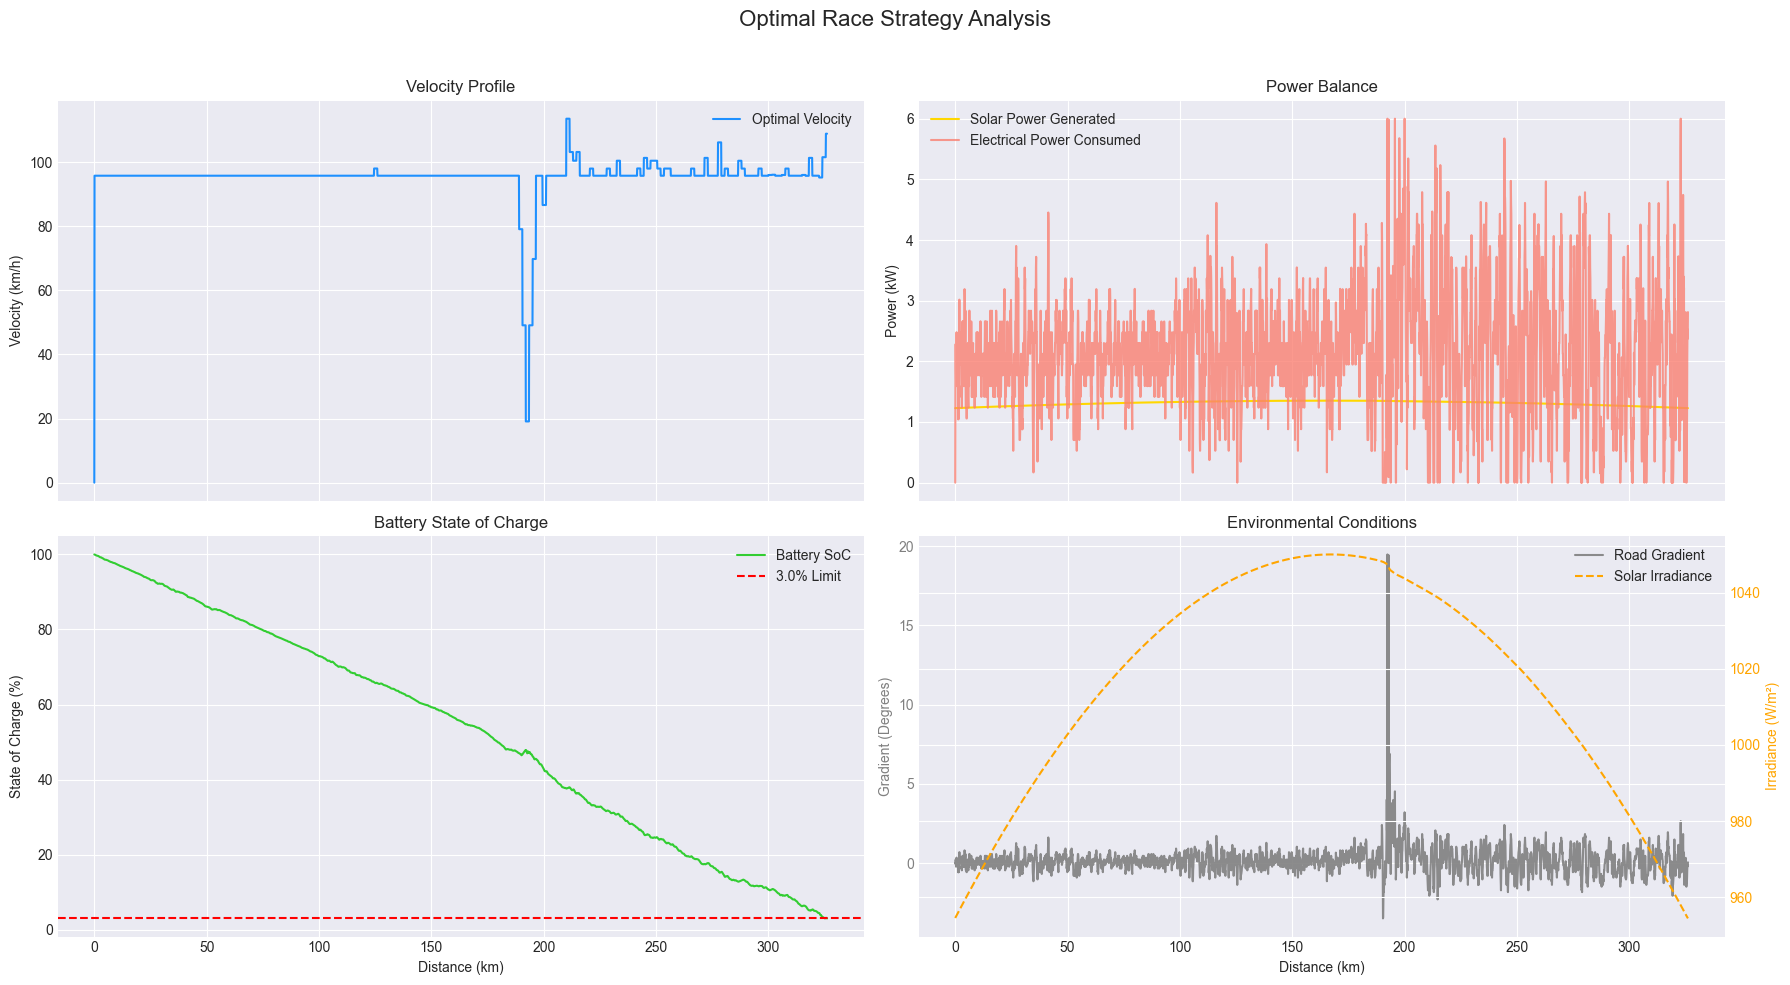

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 30.0,
        "max_deceleration_kph_per_chunk": 30.0,
    }

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    F_tractive = np.maximum(0, F_resistive)
    P_mech_watts = F_tractive * velocities_mps
    P_elec_watts = P_mech_watts / params['drivetrain_efficiency']

    # --- Battery Current ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    # Calculate the continuous time elapsed from the start of the race day
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    # CHANGED: Call the new synthetic function
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 1500
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 9.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 100
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

Cleaned route data: Removed 0 duplicate GPS points.
--- AgniRath Race Strategy Optimization ---
Route distance: 326.1 km
Optimizing 218 velocity chunks + 1 start time variable.

Starting optimization with enhanced debugging...
  ... Iteration 5/100 complete.
     Current constraint violation: 0.082726
  ... Iteration 10/100 complete.
     Current constraint violation: 0.106651
     Worst violation: Minimum SOC Violation - -0.0064
  ... Iteration 15/100 complete.
     Current constraint violation: 0.000077
  ... Iteration 20/100 complete.
     Current constraint violation: 0.000015
     Worst violation: Minimum SOC Violation - -0.0000
  ... Iteration 25/100 complete.
     Current constraint violation: 0.000000
  ... Iteration 30/100 complete.
     Current constraint violation: 0.000000
     Worst violation: Minimum SOC Violation - -0.0000
  ... Iteration 35/100 complete.
     Current constraint violation: 0.000000
  ... Iteration 40/100 complete.
     Current constraint violation: 0.000

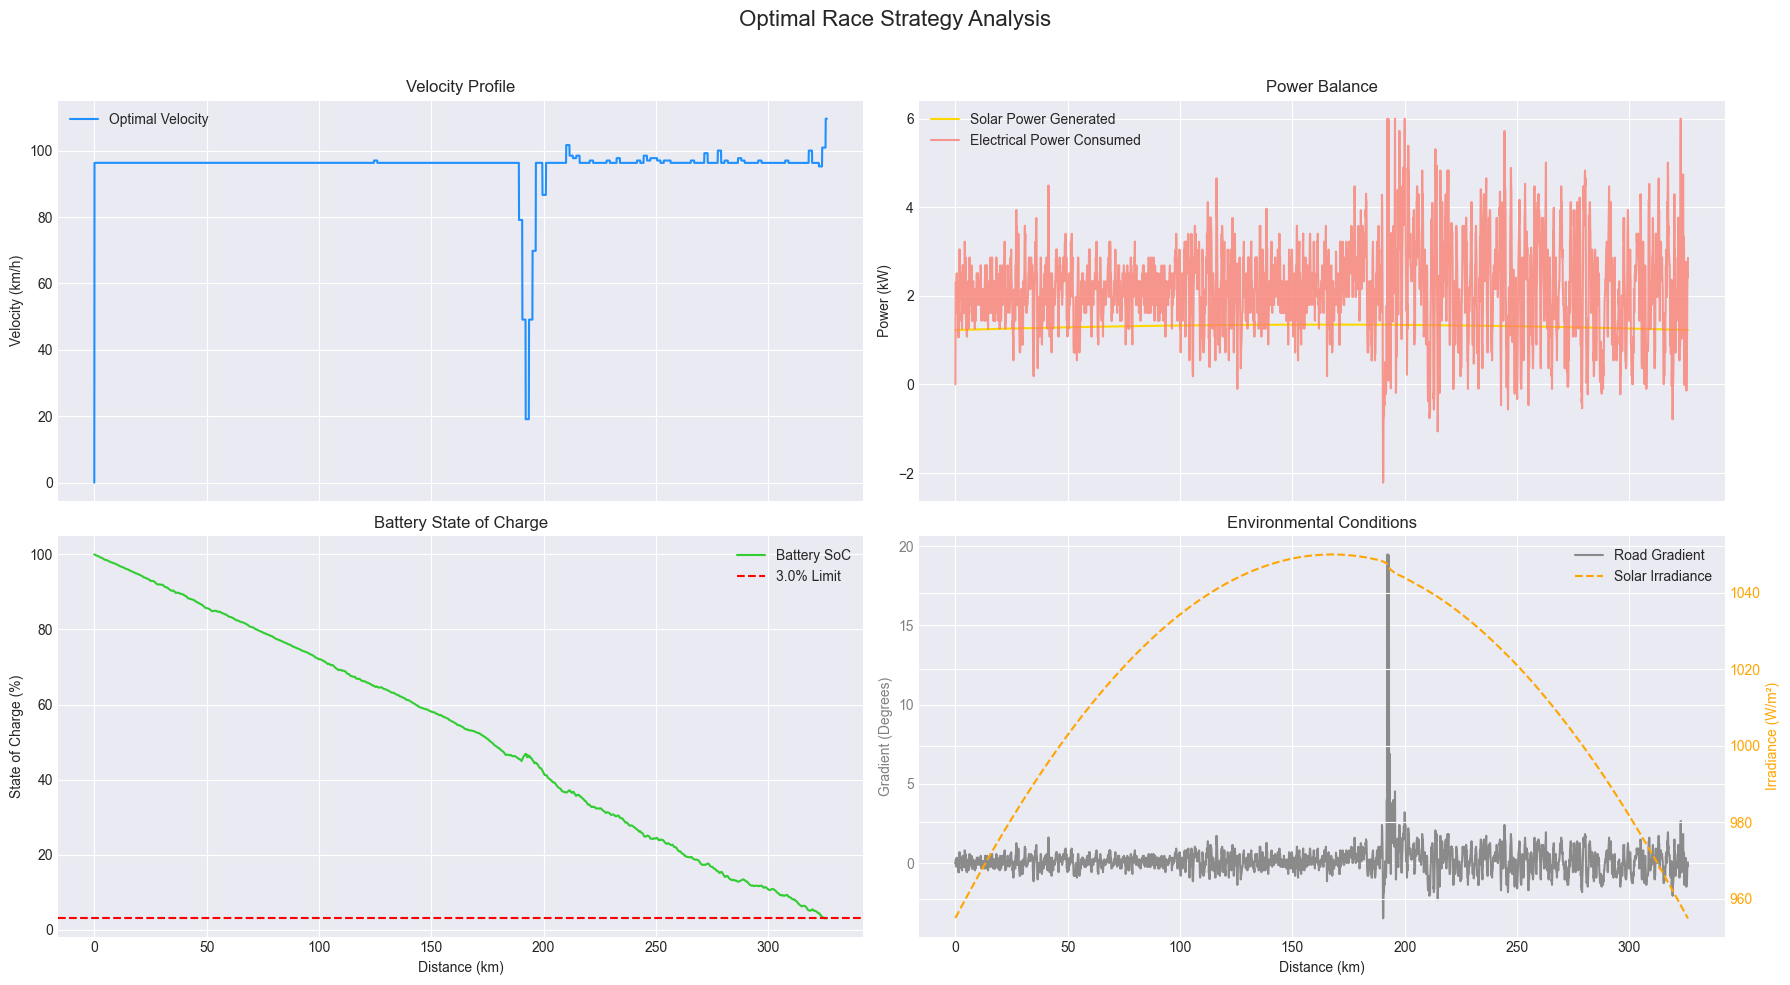

In [ ]:
# ... Iteration 45/100 complete.
#      Current constraint violation: 0.000000
# Optimization terminated successfully    (Exit mode 0)
#             Current function value: 12534.54217216733
#             Iterations: 47
#             Function evaluations: 10367
#             Gradient evaluations: 47
# Optimization finished in 25.31 seconds.

# ================================================================================
# COMPREHENSIVE OPTIMIZATION ANALYSIS
# ================================================================================

# Optimization status: Optimization terminated successfully
# Final function value: 12534.54
# Iterations: 47
# Constraint violation: 0.000000

# Best solution found (violation: 0.000000):
#   Start hour: 10.38
#   Velocities: [ 96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  97.
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  96.3  96.3  96.3  96.3  96.3  79.1  49.1  19.1  49.1  69.8  96.3
#   96.3  86.7  96.3  96.3  96.3  96.3  96.3  96.3 101.7  98.5  97.7  98.5
#   96.3  96.3  96.3  97.   96.3  96.3  96.3  96.3  97.   96.3  96.3  97.7
#   96.3  96.3  96.3  96.3  96.3  97.   96.3  98.5  97.   97.7  97.7  97.
#   96.3  97.   97.   96.3  96.3  96.3  96.3  96.3  96.3  97.   96.3  96.3
#   96.3  99.2  96.3  96.3  96.3 100.   96.3  97.   96.3  96.3  96.3  97.7
#   97.   96.3  96.3  96.3  96.3  97.   96.3  96.3  96.3  96.3  96.3  96.3
#   96.3  97.   96.3  96.3  96.3  96.3  96.3  96.3 100.   96.3  96.3  95.2
#  100.9 109.6]

# DETAILED SIMULATION ANALYSIS:
#   Race time: 3.48 hours
#   Min SOC: 3.0% (limit: 3.0%)
#   Max SOC: 100.0% (limit: 102.0%)
#   Max battery current: 50.0A (limit: 50.0A)
#   Average velocity: 95.4 km/h

# ✅ --- Optimal Strategy Found ---
# Optimal Race Start Time: 10:23
# Minimized Race Time: 3.48 hours
# Total Solar Energy Generated: 4.56 kWh
# Total Electrical Energy Consumed: 7.47 kWh
# Final Battery Level: 3.0% (0.09 kWh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        "regen_efficiency": 0.70, # ADDED: Efficiency of regenerative braking
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.02, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,
        
        # Acceleration limits for a smooth profile
        "max_acceleration_kph_per_chunk": 30.0,
        "max_deceleration_kph_per_chunk": 30.0,
    }

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    Simulates the race. Includes the final fix for the time-wrapping solar calculation.
    """
    velocities_mps = velocities_kph / 3.6
    
    # --- Forces and Power ---
    F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * velocities_mps**2
    F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
    F_gradient = params['vehicle_mass'] * params['gravity'] * route_df['gradient_sin_theta'].values
    F_resistive = F_drag + F_rolling + F_gradient
    # --- THIS IS THE NEW REGEN LOGIC ---
    # The required tractive force can now be positive (propulsion) or negative (braking)
    # For this model, we assume the optimizer sets a speed, and we calculate the force needed.
    # We'll treat F_resistive as the force needed to overcome the environment.
    # For a steady speed, tractive force must equal resistive force.
    F_tractive = F_resistive

    # Mechanical power is still force times velocity
    P_mech_watts = F_tractive * velocities_mps

    # Electrical power calculation now depends on the direction of energy flow
    propulsion_power = P_mech_watts / params['drivetrain_efficiency']
    regen_power = P_mech_watts * params['regen_efficiency'] # Note: P_mech will be negative here
    
    # Use np.where to choose the correct power based on whether we are accelerating or braking
    # If mechanical power > 0, we are propelling. If < 0, we are regenerating.
    P_elec_watts = np.where(P_mech_watts >= 0, propulsion_power, regen_power)
    
    # --- Battery Current ---
    # Current going OUT of the battery is positive, INTO the battery (charging) is negative
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    
    # --- Time and Energy Simulation (no changes needed here) ---
    segment_distances = route_df['segment_distance_m'].values
    delta_t_s = segment_distances / (velocities_mps + 1e-9)
    total_time_s = np.sum(delta_t_s)
    
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    # P_net_watts is now solar IN + regen IN - propulsion OUT
    P_net_watts = P_solar_watts - P_elec_watts
    
    delta_energy_joules = P_net_watts * delta_t_s
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts}
    
    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    Creates a smooth acceleration from 0 km/h at the start.
    """
    # Get the cumulative distance for each high-resolution segment
    cumulative_dist = route_df['cumulative_distance_m'].values
    
    # Determine which chunk each segment belongs to by its distance
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    
    # Use the indices to create the full-length velocity profile from the chunk velocities
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # NEW: Create smooth acceleration from 0 km/h over the first 100 meters
    acceleration_zone = cumulative_dist <= 100.0  # First 100 meters
    if np.any(acceleration_zone):
        # Get the target velocity after acceleration zone
        target_velocity = full_velocity_profile[~acceleration_zone][0] if len(full_velocity_profile[~acceleration_zone]) > 0 else full_velocity_profile[-1]
        
        # Create linear acceleration from 0 to target velocity
        dist_in_zone = cumulative_dist[acceleration_zone]
        max_dist_in_zone = np.max(dist_in_zone)
        if max_dist_in_zone > 0:
            acceleration_factor = dist_in_zone / max_dist_in_zone
            full_velocity_profile[acceleration_zone] = acceleration_factor * target_velocity
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    
# ADD THIS ENTIRE NEW FUNCTION
def acceleration_constraint(decision_vars, params):
    """
    Ensures the change in velocity between consecutive chunks is not too extreme.
    This constraint is independent of the main simulation.
    """
    # Unpack only the chunk velocities, ignoring the start time
    chunk_velocities = decision_vars[1:]
    
    # Calculate the difference between each adjacent velocity chunk
    velocity_changes = np.diff(chunk_velocities) # e.g., [v2-v1, v3-v2, ...]
    
    # Constraint 1: Acceleration limit (must be >= 0)
    # max_accel - (v_next - v_prev) >= 0
    c_accel = params['max_acceleration_kph_per_chunk'] - velocity_changes
    
    # Constraint 2: Deceleration limit (must be >= 0)
    # (v_next - v_prev) - (-max_decel) >= 0  -->  v_change + max_decel >= 0
    c_decel = velocity_changes + params['max_deceleration_kph_per_chunk']
    
    # Stack both constraint arrays into one. The optimizer will check them all.
    return np.hstack([c_accel, c_decel])

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 1500
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    # Better initial guess - start slower and ramp up
    initial_start_hour = 9.0
    initial_velocities = np.linspace(20.0, 60.0, num_chunks)  # Gradual increase
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 12.0)
    velocity_bounds = [(0.0, 130.0) for _ in range(num_chunks)]  # Allow starting at 0
    bounds = [start_hour_bounds] + velocity_bounds
    
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    soc_constraint_def = {'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}
    accel_constraint_def = {'type': 'ineq', 'fun': acceleration_constraint, 'args': (vehicle_params,)}
    
    # --- Setup the ADVANCED Progress Callback ---
    MAX_ITER = 100
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization with enhanced debugging...")
    start_time = time.time()
    
    try:
        result = minimize(
            objective_function,
            initial_guess,
            args=args_tuple,
            method='SLSQP',
            bounds=bounds,
            constraints=[soc_constraint_def, accel_constraint_def],
            callback=progress_callback,
            options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-7}
        )
        
    except Exception as e:
        print(f"❌ Optimization crashed: {e}")
        result = None
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")
    
    # --- COMPREHENSIVE RESULTS ANALYSIS ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            print("\n✅ --- Optimal Strategy Found ---")
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            print("\n⚠️ --- Optimization Timed Out: Using Best Intermediate Solution Found ---")
            solution_x = progress_callback.last_valid_x
        else:
            print("\n❌ Optimization failed and no valid intermediate solution was found.")
            # Try a fallback: simple constant velocity strategy
            print("Attempting fallback strategy...")
            fallback_velocity = 40.0  # Conservative fallback
            fallback_guess = np.insert(np.full(num_chunks, fallback_velocity), 0, 10.0)
            fallback_constraints = constraint_function(fallback_guess, *args_tuple)
            
            if np.all(fallback_constraints >= 0):
                print("✅ Fallback strategy is feasible, using it.")
                solution_x = fallback_guess
            else:
                print("❌ Fallback strategy also violates constraints.")
                print("Please relax your constraints (increase min_SoC or max_current).")
        
        if solution_x is not None:





            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            optimal_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, final_battery_current, final_delta_t_s = run_race_simulation(
                optimal_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            final_time_hr = final_time_s / 3600.0
            print(f"Optimal Race Start Time: {int(optimal_start_hour)}:{int((optimal_start_hour % 1) * 60):02d}")
            print(f"Minimized Race Time: {final_time_hr:.2f} hours")
            
            total_solar_energy_generated_J = np.sum(final_power['solar_gen_W'] * final_delta_t_s)
            total_electrical_energy_consumed_J = np.sum(final_power['elec_cons_W'] * final_delta_t_s)
            final_battery_energy_J = final_soc[-1] * vehicle_params['battery_capacity_joules']

            print(f"Total Solar Energy Generated: {total_solar_energy_generated_J / 3.6e6:.2f} kWh")
            print(f"Total Electrical Energy Consumed: {total_electrical_energy_consumed_J / 3.6e6:.2f} kWh")
            print(f"Final Battery Level: {final_soc[-1]*100:.1f}% ({final_battery_energy_J / 3.6e6:.2f} kWh)")
            
            # --- ENHANCED VISUALIZATION ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            # CHANGED: Switched to a 2x2 grid for better layout
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis', fontsize=16)
            
            # 1. Velocity Profile
            ax[0, 0].plot(distance_km, optimal_velocities_kph, label='Optimal Velocity', color='dodgerblue')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
            
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()

            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])

            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis

            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')

            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')

            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import requests

# ==============================================================================
# 1. SETUP: PARAMETERS AND INPUT DATA
# ==============================================================================

def get_vehicle_parameters():
    """Returns a dictionary of all vehicle and environmental constants."""
    return {
        # Vehicle Parameters (As per new requirements)
        "vehicle_mass": 330.0,
        "drag_area_CdA": 0.13,
        "coeff_rolling_resistance_Crr": 0.0045,
        "drivetrain_efficiency": 0.97,
        "regen_efficiency": 0.70, # ADDED: Efficiency of regenerative braking
        
        # Battery (As per new requirements)
        "battery_capacity_joules": 3 * 3.6e6, # 3 kWh
        "initial_SoC": 1.0,
        "min_SoC": 0.03,
        "max_SoC": 1.01, # ADDED: The battery cannot exceed 100% with a buffer
        "max_battery_current_a": 50.0,
        "battery_voltage_v": 120.0,

        # Solar Array (As per new requirements)
        "solar_panel_area": 5.85,
        "solar_panel_efficiency": 0.22,

        # Environmental
        "air_density": 1.225,
        "gravity": 9.81,

        # CHANGED: Replaced chunk-based limits with a physical force limit
        "max_acceleration_force_n": 500.0, # Max force in Newtons for acceleration
        
    }

def get_synthetic_solar_irradiance(time_of_day_hours):
    """
    A more realistic synthetic clear-sky solar model for Southern India (approx. 13° N)
    in May/June.
    """
    # Sunrise/sunset times for Chennai in May/June are approx. 5:45 AM and 6:30 PM
    sunrise = 5.75  # 5:45 AM
    sunset = 18.5   # 6:30 PM
    
    # Peak solar irradiance in India on a clear day is around 1050 W/m^2
    peak_irradiance = 1050.0

    # Create a boolean mask for daylight hours
    daylight_hours = (time_of_day_hours >= sunrise) & (time_of_day_hours <= sunset)
    
    # Calculate the angle for the sinusoidal model based on the new times
    angle = np.pi * (time_of_day_hours - sunrise) / (sunset - sunrise)
    
    # Calculate irradiance, ensuring it's never negative
    sinusoidal_irradiance = peak_irradiance * np.sin(angle)
    sinusoidal_irradiance = np.maximum(0, sinusoidal_irradiance)
    
    # Apply the daylight mask
    irradiance = np.where(daylight_hours, sinusoidal_irradiance, 0.0)
    return irradiance

# REPLACE your load_route_data function with this more robust version

def load_route_data(filename='Agnirath_app/route_data_resampled.csv'):
    """Loads, cleans, and prepares the route data."""
    df = pd.read_csv(filename)
    
    # --- Clean the GPS Data by removing duplicates ---
    is_duplicate = (df['latitude'].diff() == 0) & (df['longitude'].diff() == 0)
    df_cleaned = df[~is_duplicate].reset_index(drop=True)
    print(f"Cleaned route data: Removed {len(df) - len(df_cleaned)} duplicate GPS points.")
    
    # --- ADDED: Smooth the altitude data to remove noise ---
    # A window of 5 means we average the current point with 2 points before and 2 after.
    df_cleaned['altitude_m_smoothed'] = df_cleaned['altitude_m'].rolling(window=5, center=True, min_periods=1).mean()

    # All subsequent calculations use the cleaned and smoothed data
    distances_m = haversine_distance(df_cleaned['latitude'].iloc[:-1].values, 
                                     df_cleaned['longitude'].iloc[:-1].values, 
                                     df_cleaned['latitude'].iloc[1:].values, 
                                     df_cleaned['longitude'].iloc[1:].values)
    
    df_cleaned['segment_distance_m'] = np.insert(distances_m, 0, 0)
    
    # Use the new SMOOTHED altitude for gradient calculation
    altitudes_m = df_cleaned['altitude_m_smoothed'].to_numpy()
    altitude_changes_m = np.diff(altitudes_m)

    sin_theta = np.divide(altitude_changes_m, distances_m, 
                          out=np.zeros_like(distances_m), 
                          where=distances_m!=0)
    
    df_cleaned['gradient_sin_theta'] = np.insert(np.nan_to_num(sin_theta), 0, 0)
    df_cleaned['cumulative_distance_m'] = df_cleaned['segment_distance_m'].cumsum()
    
    return df_cleaned

def haversine_distance(lat1, lon1, lat2, lon2):
    """Helper function to calculate distance between GPS points."""
    R = 6371000  # Earth radius in meters
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    
    # --- THIS IS THE DEFINITIVE FIX ---
    # Clip 'a' to handle potential floating-point inaccuracies where a > 1.
    # This prevents taking the square root of a negative number.
    a = np.clip(a, 0, 1)
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ==============================================================================
# 2. PHYSICS AND ENERGY SIMULATION MODEL
# ==============================================================================

def check_array(name, arr):
    """A helper function to print stats and check for invalid numbers in an array."""
    # Check for NaN or Inf values. This is the most important check.
    if np.isnan(arr).any() or np.isinf(arr).any():
        print(f"  !!!!!! FATAL WARNING: NaN or Inf detected in '{name}'! !!!!!!")
        # Print details about where the invalid values are
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        print(f"  -> Contains {nan_count} NaN(s) and {inf_count} Inf(s).")
        return True # Return True to indicate an error was found
    
    # If the array is valid, print its basic stats
    print(f"  [OK] Checking {name}: min={np.min(arr):.2f}, max={np.max(arr):.2f}, mean={np.mean(arr):.2f}")
    return False

# REPLACE your run_race_simulation function with this
def run_race_simulation(velocities_kph, route_df, params, start_hour):
    """
    A true dynamic simulation that models acceleration and momentum between segments.
    """
    target_velocities_mps = velocities_kph / 3.6
    num_segments = len(route_df)
    
    # Initialize arrays to store the results of our step-by-step simulation
    actual_velocities_mps = np.zeros(num_segments)
    F_tractive = np.zeros(num_segments)
    P_elec_watts = np.zeros(num_segments)
    delta_t_s = np.zeros(num_segments)
    
    segment_distances = route_df['segment_distance_m'].values
    sin_theta = route_df['gradient_sin_theta'].values
    
    # --- Step-by-Step Dynamic Simulation Loop ---
    for i in range(1, num_segments):
        # The car's current speed is its speed from the end of the last segment
        current_v = actual_velocities_mps[i-1]
        
        # Calculate resistive forces at the CURRENT speed
        F_drag = 0.5 * params['air_density'] * params['drag_area_CdA'] * current_v**2
        F_rolling = params['coeff_rolling_resistance_Crr'] * params['vehicle_mass'] * params['gravity']
        F_gradient = params['vehicle_mass'] * params['gravity'] * sin_theta[i]
        F_resistive = F_drag + F_rolling + F_gradient
        
        # --- Kinematics: Calculate force needed to reach the TARGET speed ---
        target_v = target_velocities_mps[i]
        
        # Use kinematics (vf^2 = vi^2 + 2*a*d) to find the required acceleration 'a'
        # a = (vf^2 - vi^2) / (2*d)
        if segment_distances[i] > 0:
            required_accel = (target_v**2 - current_v**2) / (2 * segment_distances[i])
        else:
            required_accel = 0
            
        # Force needed for that acceleration (F=ma)
        F_inertial = params['vehicle_mass'] * required_accel
        
        # The total tractive force is the force to overcome resistance PLUS the force to accelerate
        total_force_needed = F_resistive + F_inertial
        
        # --- Apply Physical Limits ---
        # The motor can only provide a certain amount of acceleration force
        # and it cannot pull backwards (regen is handled by negative resistive force)
        F_tractive[i] = np.clip(total_force_needed, 0, F_resistive + params['max_acceleration_force_n'])
        
        # Recalculate the actual acceleration and final velocity based on the limited force
        actual_accel = (F_tractive[i] - F_resistive) / params['vehicle_mass']
        final_v_sq = current_v**2 + 2 * actual_accel * segment_distances[i]
        actual_velocities_mps[i] = np.sqrt(max(0, final_v_sq))
        
        # --- Final Power Calculation for this Segment ---
        P_mech_watts = F_tractive[i] * actual_velocities_mps[i]
        propulsion_power = P_mech_watts / params['drivetrain_efficiency']
        regen_power = P_mech_watts * params['regen_efficiency']
        P_elec_watts[i] = np.where(P_mech_watts >= 0, propulsion_power, regen_power)
        
        # Calculate time spent in this segment
        avg_v = (current_v + actual_velocities_mps[i]) / 2
        delta_t_s[i] = segment_distances[i] / (avg_v + 1e-9)

    # --- Energy simulation (this part remains vectorized) ---
    battery_current_a = P_elec_watts / params['battery_voltage_v']
    total_time_s = np.sum(delta_t_s)
    
    time_of_day_hours = start_hour + np.cumsum(delta_t_s) / 3600.0
    time_of_day_wrapped = time_of_day_hours % 24
    
    P_solar_watts = get_synthetic_solar_irradiance(time_of_day_wrapped) * \
                    params['solar_panel_area'] * \
                    params['solar_panel_efficiency']
                    
    P_net_watts = P_solar_watts - P_elec_watts
    delta_energy_joules = P_net_watts * delta_t_s
    
    initial_energy = params['battery_capacity_joules'] * params['initial_SoC']
    cumulative_energy_joules = initial_energy + np.cumsum(delta_energy_joules)
    soc_profile = cumulative_energy_joules / params['battery_capacity_joules']
    
    power_profile = {'solar_gen_W': P_solar_watts, 'elec_cons_W': P_elec_watts, 'actual_velocity_kph': actual_velocities_mps * 3.6}

    return total_time_s, soc_profile, power_profile, battery_current_a, delta_t_s

# ==============================================================================
# 3. OPTIMIZATION SETUP
# ==============================================================================

# ==============================================================================
# ENHANCED DEBUGGING SYSTEM
# ==============================================================================

class AdvancedOptimizationCallback:
    """
    A comprehensive callback that tracks constraints and identifies exactly why optimization fails.
    """
    def __init__(self, max_iterations, constraint_func, constraint_args, bounds, params):
        self.iteration_count = 0
        self.max_iterations = max_iterations
        self.constraint_func = constraint_func
        self.constraint_args = constraint_args
        self.bounds = bounds
        self.params = params
        self.last_valid_x = None
        self.best_constraint_violation = float('inf')
        self.constraint_history = []
        
    def __call__(self, xk):
        """This method is called by the optimizer at each iteration."""
        self.iteration_count += 1
        
        # Check constraints and get detailed violation info
        constraint_violations, violation_details = self.analyze_constraints(xk)
        total_violation = np.sum(np.abs(constraint_violations[constraint_violations < 0]))
        
        # Store the best solution found so far
        if total_violation < self.best_constraint_violation:
            self.best_constraint_violation = total_violation
            self.last_valid_x = xk.copy()
            self.best_violation_details = violation_details
        
        if self.iteration_count % 5 == 0:
            print(f"  ... Iteration {self.iteration_count}/{self.max_iterations} complete.")
            print(f"     Current constraint violation: {total_violation:.6f}")
            
            # Print worst violations every 10 iterations
            if self.iteration_count % 10 == 0 and violation_details:
                worst_violation = violation_details[0]
                print(f"     Worst violation: {worst_violation['type']} - {worst_violation['value']:.4f}")

    def analyze_constraints(self, xk):
        """Analyze exactly which constraints are violated and why."""
        constraints = self.constraint_func(xk, *self.constraint_args)
        violation_details = []
        
        # Analyze SOC constraints
        soc_constraints = constraints[:len(constraints)//3]  # First third are SOC constraints
        min_soc_violations = soc_constraints[soc_constraints < 0]
        if len(min_soc_violations) > 0:
            worst_violation = np.min(min_soc_violations)
            violation_details.append({
                'type': 'Minimum SOC Violation',
                'value': worst_violation,
                'message': f"Battery drops to {self.params['min_SoC'] + worst_violation:.3f} (limit: {self.params['min_SoC']})"
            })
        
        # Analyze Max SOC constraints  
        max_soc_constraints = constraints[len(constraints)//3:2*len(constraints)//3]
        max_soc_violations = max_soc_constraints[max_soc_constraints < 0]
        if len(max_soc_violations) > 0:
            worst_violation = np.min(max_soc_violations)
            violation_details.append({
                'type': 'Maximum SOC Violation', 
                'value': worst_violation,
                'message': f"Battery exceeds {self.params['max_SoC'] - worst_violation:.3f} (limit: {self.params['max_SoC']})"
            })
        
        # Analyze current constraints
        current_constraints = constraints[2*len(constraints)//3:]
        current_violations = current_constraints[current_constraints < 0]
        if len(current_violations) > 0:
            worst_violation = np.min(current_violations)
            violation_details.append({
                'type': 'Battery Current Violation',
                'value': worst_violation, 
                'message': f"Current exceeds {self.params['max_battery_current_a'] - worst_violation:.1f}A (limit: {self.params['max_battery_current_a']}A)"
            })
        
        # Sort by worst violation
        violation_details.sort(key=lambda x: x['value'])
        
        return constraints, violation_details

    def print_final_diagnostic(self, result):
        """Print comprehensive diagnostic information when optimization fails."""
        print("\n" + "="*80)
        print("COMPREHENSIVE OPTIMIZATION FAILURE ANALYSIS")
        print("="*80)
        
        print(f"\nOptimization status: {result.message}")
        print(f"Final function value: {result.fun:.2f}")
        print(f"Iterations: {result.nit}")
        print(f"Constraint violation: {self.best_constraint_violation:.6f}")
        
        if self.last_valid_x is not None:
            print(f"\nBest solution found (violation: {self.best_constraint_violation:.6f}):")
            print(f"  Start hour: {self.last_valid_x[0]:.2f}")
            print(f"  Velocities: {self.last_valid_x[1:].round(1)}")
            
            if hasattr(self, 'best_violation_details') and self.best_violation_details:
                print(f"\nCONSTRAINT VIOLATIONS IN BEST SOLUTION:")
                for i, violation in enumerate(self.best_violation_details[:3]):  # Top 3 violations
                    print(f"  {i+1}. {violation['type']}: {violation['message']}")
            
            # Run simulation on best solution to get detailed diagnostics
            self.detailed_simulation_analysis(self.last_valid_x)
        else:
            print("\n❌ NO VALID SOLUTION FOUND - Constraints too strict or initial guess infeasible")
            self.analyze_initial_feasibility()
    
    def detailed_simulation_analysis(self, xk):
        """Run simulation on the solution and analyze why constraints are violated."""
        start_hour = xk[0]
        chunk_velocities = xk[1:]
        route_df, params, chunk_size_m = self.constraint_args
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        total_time_s, soc_profile, power_profile, battery_current, delta_t_s = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        print(f"\nDETAILED SIMULATION ANALYSIS:")
        print(f"  Race time: {total_time_s/3600:.2f} hours")
        print(f"  Min SOC: {np.min(soc_profile)*100:.1f}% (limit: {params['min_SoC']*100}%)")
        print(f"  Max SOC: {np.max(soc_profile)*100:.1f}% (limit: {params['max_SoC']*100}%)") 
        print(f"  Max battery current: {np.max(battery_current):.1f}A (limit: {params['max_battery_current_a']}A)")
        print(f"  Average velocity: {np.mean(velocities_kph):.1f} km/h")
        
        # Identify exactly where violations occur
        if np.min(soc_profile) < params['min_SoC']:
            min_idx = np.argmin(soc_profile)
            print(f"  ❌ SOC violation at segment {min_idx}, distance: {route_df['cumulative_distance_m'].iloc[min_idx]/1000:.1f}km")
        
        if np.max(soc_profile) > params['max_SoC']:
            max_idx = np.argmax(soc_profile) 
            print(f"  ❌ SOC overcharge at segment {max_idx}, distance: {route_df['cumulative_distance_m'].iloc[max_idx]/1000:.1f}km")
            
        if np.max(battery_current) > params['max_battery_current_a']:
            current_idx = np.argmax(battery_current)
            print(f"  ❌ Current violation at segment {current_idx}, distance: {route_df['cumulative_distance_m'].iloc[current_idx]/1000:.1f}km")
    
    def analyze_initial_feasibility(self):
        """Check if the initial guess and bounds are feasible."""
        print(f"\nINITIAL FEASIBILITY ANALYSIS:")
        
        # Check bounds
        print(f"  Start hour bounds: {self.bounds[0]}")
        print(f"  Velocity bounds: {self.bounds[1][0]} to {self.bounds[-1][1]} km/h")
        
        # Check if constraints are physically possible
        route_df, params, chunk_size_m = self.constraint_args
        total_distance = route_df['cumulative_distance_m'].iloc[-1]
        min_energy_required = total_distance * params['vehicle_mass'] * params['gravity'] * params['coeff_rolling_resistance_Crr'] / params['drivetrain_efficiency']
        battery_capacity_joules = params['battery_capacity_joules'] * (params['initial_SoC'] - params['min_SoC'])
        
        print(f"  Total distance: {total_distance/1000:.1f} km")
        print(f"  Minimum energy required: {min_energy_required/3.6e6:.2f} kWh")
        print(f"  Usable battery capacity: {battery_capacity_joules/3.6e6:.2f} kWh")
        
        if min_energy_required > battery_capacity_joules:
            print("  ❌ PHYSICAL IMPOSSIBILITY: Required energy exceeds battery capacity!")
            print("     Solution: Increase battery capacity or reduce distance/rolling resistance")


def map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m):
    """
    Takes a small array of velocities and maps them to the full route.
    """
    cumulative_dist = route_df['cumulative_distance_m'].values
    segment_chunk_indices = np.floor(cumulative_dist / chunk_size_m).astype(int)
    segment_chunk_indices = np.clip(segment_chunk_indices, 0, len(chunk_velocities) - 1)
    full_velocity_profile = chunk_velocities[segment_chunk_indices]
    
    # Force start at 0, which is physically correct. The simulation will handle the ramp up.
    full_velocity_profile[0] = 0.0 
    
    return full_velocity_profile

# REPLACE the old objective_function with this one
def objective_function(decision_vars, route_df, params, chunk_size_m): # No interpolator
    start_hour = decision_vars[0]
    chunk_velocities = decision_vars[1:]
    velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
    total_time_s, _, _, _, _ = run_race_simulation(
        velocities_kph, route_df, params, start_hour
    )
    return total_time_s

# ==============================================================================
# IMPROVED CONSTRAINT FUNCTION WITH BETTER DEBUGGING
# ==============================================================================

def constraint_function(decision_vars, route_df, params, chunk_size_m):
    """
    The constraint function with better error handling and validation.
    """
    try:
        start_hour = decision_vars[0]
        chunk_velocities = decision_vars[1:]
        
        # Validate inputs
        if start_hour < 0 or start_hour > 24:
            raise ValueError(f"Invalid start hour: {start_hour}")
        
        if np.any(chunk_velocities < 0):
            raise ValueError("Negative velocities detected")
        
        velocities_kph = map_chunk_velocities_to_segments(chunk_velocities, route_df, chunk_size_m)
        
        _, soc_profile, _, battery_current_profile, _ = run_race_simulation(
            velocities_kph, route_df, params, start_hour
        )
        
        # Constraint 1: SoC must be ABOVE the minimum
        c1_min_soc = soc_profile - params['min_SoC']
        
        # Constraint 2: SoC must be BELOW the maximum  
        c2_max_soc = params['max_SoC'] - soc_profile
        
        # Constraint 3: Battery current must be below the maximum
        c3_battery_current = params['max_battery_current_a'] - battery_current_profile
        
        return np.hstack([c1_min_soc, c2_max_soc, c3_battery_current])
        
    except Exception as e:
        print(f"❌ Constraint function error: {e}")
        # Return a large violation to guide optimizer away from problematic regions
        return np.array([-1000.0])
    

# ==============================================================================
# 4. MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
    # --- Load Inputs ---
    vehicle_params = get_vehicle_parameters()
    route_data = load_route_data()
    
    # --- Define Optimization Problem ---
    CHUNK_SIZE_M = 500
    num_chunks = int(np.ceil(route_data['cumulative_distance_m'].iloc[-1] / CHUNK_SIZE_M))
    
    print("--- AgniRath Race Strategy Optimization (Dynamic Model) ---")
    print(f"Route distance: {route_data['cumulative_distance_m'].iloc[-1] / 1000:.1f} km")
    print(f"Optimizing {num_chunks} velocity chunks + 1 start time variable.")
    
    initial_start_hour = 10.0
    initial_velocities = np.full(num_chunks, 60.0)
    initial_guess = np.insert(initial_velocities, 0, initial_start_hour)
    
    start_hour_bounds = (8.0, 13.0)
    velocity_bounds = [(10.0, 130.0) for _ in range(num_chunks)]
    bounds = [start_hour_bounds] + velocity_bounds
    
    # --- Setup Arguments and Constraints ---
    args_tuple = (route_data, vehicle_params, CHUNK_SIZE_M)
    
    # The constraints list is now simpler, containing only the main simulation constraint
    constraints = [{'type': 'ineq', 'fun': constraint_function, 'args': args_tuple}]
    # REMOVED: The accel_constraint_def line has been deleted.

    # --- Setup the Progress Callback ---
    MAX_ITER = 20
    progress_callback = AdvancedOptimizationCallback(
        max_iterations=MAX_ITER,
        constraint_func=constraint_function,
        constraint_args=args_tuple,
        bounds=bounds,
        params=vehicle_params
    )
    
    # --- Run the Optimizer ---
    print("\nStarting optimization...")
    start_time = time.time()
    
    result = minimize(
        objective_function,
        initial_guess,
        args=args_tuple,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints, # Use the simplified constraints list
        callback=progress_callback,
        options={'disp': True, 'maxiter': MAX_ITER, 'ftol': 1e-6}
    )
    
    end_time = time.time()
    print(f"Optimization finished in {end_time - start_time:.2f} seconds.")

    # --- Run Final Analysis and Plotting ---
    if result is not None:
        progress_callback.print_final_diagnostic(result)
        
        solution_x = None
        if result.success:
            solution_x = result.x
        elif progress_callback.last_valid_x is not None:
            solution_x = progress_callback.last_valid_x

        if solution_x is not None:
            # Rerun the simulation with the final solution to get all data for plotting
            optimal_start_hour = solution_x[0]
            optimal_chunk_velocities = solution_x[1:]
            
            # NOTE: This is the TARGET profile. The SIMULATION will give the ACTUAL profile.
            target_velocities_kph = map_chunk_velocities_to_segments(
                optimal_chunk_velocities, route_data, CHUNK_SIZE_M
            )
            
            final_time_s, final_soc, final_power, _, _ = run_race_simulation(
                target_velocities_kph, route_data, vehicle_params, optimal_start_hour
            )
            
            # Get the actual velocity profile, which includes the effects of acceleration limits
            actual_velocities_kph = final_power['actual_velocity_kph']
            
            # --- Visualization ---
            distance_km = route_data['cumulative_distance_m'] / 1000.0
            
            plt.style.use('seaborn-v0_8-darkgrid')
            fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
            fig.suptitle('Optimal Race Strategy Analysis (Dynamic Model)', fontsize=16)
            
            # Plot the ACTUAL velocity
            ax[0, 0].plot(distance_km, actual_velocities_kph, label='Actual Velocity', color='dodgerblue')
            ax[0, 0].plot(distance_km, target_velocities_kph, label='Target Velocity', color='lightskyblue', linestyle='--')
            ax[0, 0].set_ylabel('Velocity (km/h)')
            ax[0, 0].set_title('Velocity Profile')
            ax[0, 0].legend()
                
            # 2. State of Charge (SoC)
            ax[1, 0].plot(distance_km, final_soc * 100, label='Battery SoC', color='limegreen')
            ax[1, 0].set_ylabel('State of Charge (%)')
            ax[1, 0].set_title('Battery State of Charge')
            ax[1, 0].axhline(y=vehicle_params['min_SoC']*100, color='r', linestyle='--', label=f"{vehicle_params['min_SoC']*100}% Limit")
            ax[1, 0].set_xlabel('Distance (km)')
            ax[1, 0].legend()
            
            # 3. Power Balance
            ax[0, 1].plot(distance_km, final_power['solar_gen_W'] / 1000, label='Solar Power Generated', color='gold')
            ax[0, 1].plot(distance_km, final_power['elec_cons_W'] / 1000, label='Electrical Power Consumed', color='salmon', alpha=0.8)
            ax[0, 1].set_ylabel('Power (kW)')
            ax[0, 1].set_title('Power Balance')
            ax[0, 1].legend()
            # 4. ADDED: Environmental Conditions
            gradient_degrees = np.rad2deg(np.arcsin(route_data['gradient_sin_theta']))
            irradiance_w_m2 = final_power['solar_gen_W'] / (vehicle_params['solar_panel_area'] * vehicle_params['solar_panel_efficiency'])
            ax_env = ax[1, 1]
            ax_solar = ax_env.twinx() # Create a second y-axis
            ax_env.plot(distance_km, gradient_degrees, label='Road Gradient', color='grey', alpha=0.9)
            ax_env.set_ylabel('Gradient (Degrees)', color='grey')
            ax_env.tick_params(axis='y', labelcolor='grey')
            ax_env.set_title('Environmental Conditions')
            ax_env.set_xlabel('Distance (km)')
            ax_solar.plot(distance_km, irradiance_w_m2, label='Solar Irradiance', color='orange', linestyle='--')
            ax_solar.set_ylabel('Irradiance (W/m²)', color='orange')
            ax_solar.tick_params(axis='y', labelcolor='orange')
            # To get legends from both axes to show up
            lines, labels = ax_env.get_legend_handles_labels()
            lines2, labels2 = ax_solar.get_legend_handles_labels()
            ax_solar.legend(lines + lines2, labels + labels2, loc=0)
            
            plt.tight_layout(rect=(0, 0, 1, 0.96))
            plt.show()